In [263]:
# 3. 能量响应分析：发射能量 vs 沉积能量
import matplotlib.pyplot as plt


# 检查 ROOT 文件中的所有分支
import uproot
import os

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import importlib
import data_loader

importlib.reload(data_loader)
from data_loader import load_and_process_data

from matplotlib.colors import LogNorm

## DataLoading

In [264]:
# 检查 ROOT 文件中的所有分支
import uproot
import os

root_file = "data/res2.root"
file = uproot.open(root_file)
tree = file["CsI"]

print("ROOT 文件中的所有分支:")
print("=" * 60)
for branch_name in tree.keys():
    branch = tree[branch_name]
    print(f"{branch_name:30s} {branch.typename}")
print("=" * 60)

ROOT 文件中的所有分支:
EventID                        int32_t
TotalEdep                      double
HitCount                       int32_t
CrystalID                      std::vector<int32_t>
CrystalEdep                    std::vector<double>
CrystalTime                    std::vector<double>
CrystalPosX                    std::vector<double>
CrystalPosY                    std::vector<double>
CrystalPosZ                    std::vector<double>
CrystalPDG                     std::vector<int32_t>
CrystalTrackID                 std::vector<int32_t>
CrystalParentID                std::vector<int32_t>
CrystalDirX                    std::vector<double>
CrystalDirY                    std::vector<double>
CrystalDirZ                    std::vector<double>
CrystalKineticEnergy           std::vector<double>
CrystalProcessID               std::vector<int32_t>
CrystalTrackLength             std::vector<double>
PrimaryPDG                     std::vector<int32_t>
PrimaryEnergy                  std::vector<doub

In [265]:
# 删除旧的缓存文件，以便重新生成包含所有分支的数据（包括新增的 trackLength）
import os

cache_files = ["data/res2_hits.parquet", "data/res2_primaries.parquet"]
for cache_file in cache_files:
    if os.path.exists(cache_file):
        os.remove(cache_file)
        print(f"已删除旧缓存: {cache_file}")

In [266]:
# ================== 读取与预处理数据 ==================

from data_loader import load_and_process_data

# 配置路径
root_file = "data/res2.root"
output_dir = "plots"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    # 一键加载并预处理 (会自动读取/生成 parquet 缓存)
    # 现在包含了新的 trackLength 字段
    data, df_hits, df_primaries, process_map, num_events = load_and_process_data(root_file, cache=True)

    print("\nDataFrame Preview (Hits):")
    print(df_hits.head())
    print(f"\n列名: {list(df_hits.columns)}")

    print("\nDataFrame Preview (Primaries):")
    print(df_primaries.head())

    # 为了兼容后面的绘图代码，将 DataFrame 列赋值给变量
    flat_edep = df_hits["edep"]
    flat_time = df_hits["time"]
    flat_posX = df_hits["posX"]
    flat_posY = df_hits["posY"]
    flat_pdg = df_hits["pdg"]
    flat_process = df_hits["processID"]
    flat_id = df_hits["crystalID"]
    flat_track_length = df_hits["trackLength"]  # 新增：Track Length 数据

except Exception as e:
    print(f"Error: {e}")
    import traceback

    traceback.print_exc()

[Info] Loaded 7 processes from 'data/res2_ProcessIDMap.txt'
Opening ROOT file: data/res2.root...
Successfully loaded 500000 events from ROOT.
Converting to Pandas DataFrames...
Successfully loaded 500000 events from ROOT.
Converting to Pandas DataFrames...
Processing Primary particles...
Saving DataFrame caches...
Processing Primary particles...
Saving DataFrame caches...

DataFrame Preview (Hits):
   EventID  hit_idx  crystalID      edep      time        posX        posY  \
0        0        0      70001  0.331882  0.012474  243.499718 -217.272570   
1        1        0      20601  4.978044  0.000000 -120.697688  144.375816   
2        1        1      20602  0.005026  0.148311  -90.075313  129.364381   
3        1        2      20502  0.360088  0.195654  -81.847582  121.500000   
4        1        3      10601  0.336220  0.018736 -122.500000  144.513669   

        posZ  pdg  parentID      dirX      dirY      dirZ  kineticEnergy  \
0 -63.593091   11         0 -0.975103 -0.093098  0.20

# Process

In [219]:
# ================== 关联发射粒子与探测器 Hit ==================

# 1. 将发射粒子信息合并到 Hit 数据中
# 我们使用 EventID 作为键进行合并
# suffixes=('_hit', '_primary') 用于区分同名列 (如 pdg, posX 等)
df_merged = pd.merge(df_hits, df_primaries, on="EventID", suffixes=("_hit", "_primary"))

print("合并后的 DataFrame (前 5 行):")
# 选取一些关键列进行展示
cols_to_show = ["EventID", "edep", "pdg_hit", "parentID", "pdg_primary", "energy"]
print(df_merged[cols_to_show].head())

# 2. 区分 Hit 是由初级粒子直接产生，还是由次级粒子产生
# 在 Geant4 中，通常 ParentID = 0 表示该径迹是初级粒子
# 如果 parentID == 0，说明产生这个 Hit 的粒子就是发射的粒子本身
primary_hits = df_merged[df_merged["parentID"] == 0]
secondary_hits = df_merged[df_merged["parentID"] > 0]

print(f"\n统计信息:")
print(f"  总 Hits 数: {len(df_merged)}")
print(f"  初级粒子直接产生的 Hits: {len(primary_hits)} ({len(primary_hits) / len(df_merged):.1%})")
print(f"  次级粒子产生的 Hits: {len(secondary_hits)} ({len(secondary_hits) / len(df_merged):.1%})")

合并后的 DataFrame (前 5 行):
   EventID      edep  pdg_hit  parentID  pdg_primary    energy
0        0  0.246478       11         0           11  0.843090
1        0  0.246478       11         0          -11  0.843090
2        1  5.926113      -11         0           11  3.079680
3        1  5.926113      -11         0          -11  3.079680
4        2  2.846352      -11         0           11  1.678676

统计信息:
  总 Hits 数: 2134786
  初级粒子直接产生的 Hits: 1052326 (49.3%)
  次级粒子产生的 Hits: 1082460 (50.7%)


In [ ]:
# 按 EventID 分组计算总沉积能量
event_edep = df_hits.groupby("EventID")["edep"].sum().reset_index()
event_edep.rename(columns={"edep": "total_edep"}, inplace=True)

# 合并发射能量信息
# 注意：一个事件可能有多个发射粒子，这里我们计算每个事件的总发射能量
event_primary = df_primaries.groupby("EventID")["energy"].sum().reset_index()
event_primary.rename(columns={"energy": "total_primary_energy"}, inplace=True)

# 合并两个统计结果
df_energy_corr = pd.merge(event_edep, event_primary, on="EventID")

: 

: 

: 

: 

: 

In [220]:
df_hits

,EventID,hit_idx,crystalID,edep,time,posX,posY,posZ,pdg,parentID,...,dirY,dirZ,kineticEnergy,processID,trackLength,ix,iy,iz,dEdx,particle_name
0,0,0,70001,0.246478,0.012446,243.500000,-217.280024,-63.638601,11,0,...,-0.066552,0.081382,0.331854,0,0.337743,7,0,1,0.729779,Electron
1,1,0,30000,5.926113,0.000000,-9.942948,-226.133243,-149.076349,-11,0,...,-0.754058,-0.510518,2.568682,0,15.528075,3,0,0,0.381639,Positron
2,2,0,40004,2.846352,0.000000,50.612061,-214.194216,134.017125,-11,0,...,0.954757,0.258108,1.167677,0,5.005614,4,0,4,0.568632,Positron
3,2,1,50004,0.510999,0.086264,77.145706,-224.374424,127.273105,22,2,...,0.031271,0.321972,0.108472,1,0.805886,5,0,4,0.634083,Gamma
4,3,0,60402,4.773440,0.000000,142.478758,12.545274,-14.164356,-11,0,...,0.542932,-0.619299,2.471743,0,8.805331,6,4,2,0.542108,Positron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067388,499995,0,10700,1.869134,0.000000,-144.386486,224.240529,-120.016040,-11,0,...,-0.320352,-0.202262,0.679067,0,18.323620,1,7,0,0.102007,Positron
1067389,499996,0,20100,0.405223,0.038438,-75.831520,-160.647334,-152.000000,11,0,...,0.492882,0.609244,0.405223,0,0.405097,2,1,0,1.000312,Electron
1067390,499998,0,20600,0.687879,0.000000,-102.276405,176.324268,-127.594405,-11,0,...,0.068563,-0.923773,0.016460,0,26.086718,2,6,0,0.026369,Positron
1067391,499998,1,20701,0.367038,0.214547,-104.655155,190.665560,-66.827243,22,2,...,0.062119,-0.918789,0.156469,1,5.690911,2,7,1,0.064495,Gamma


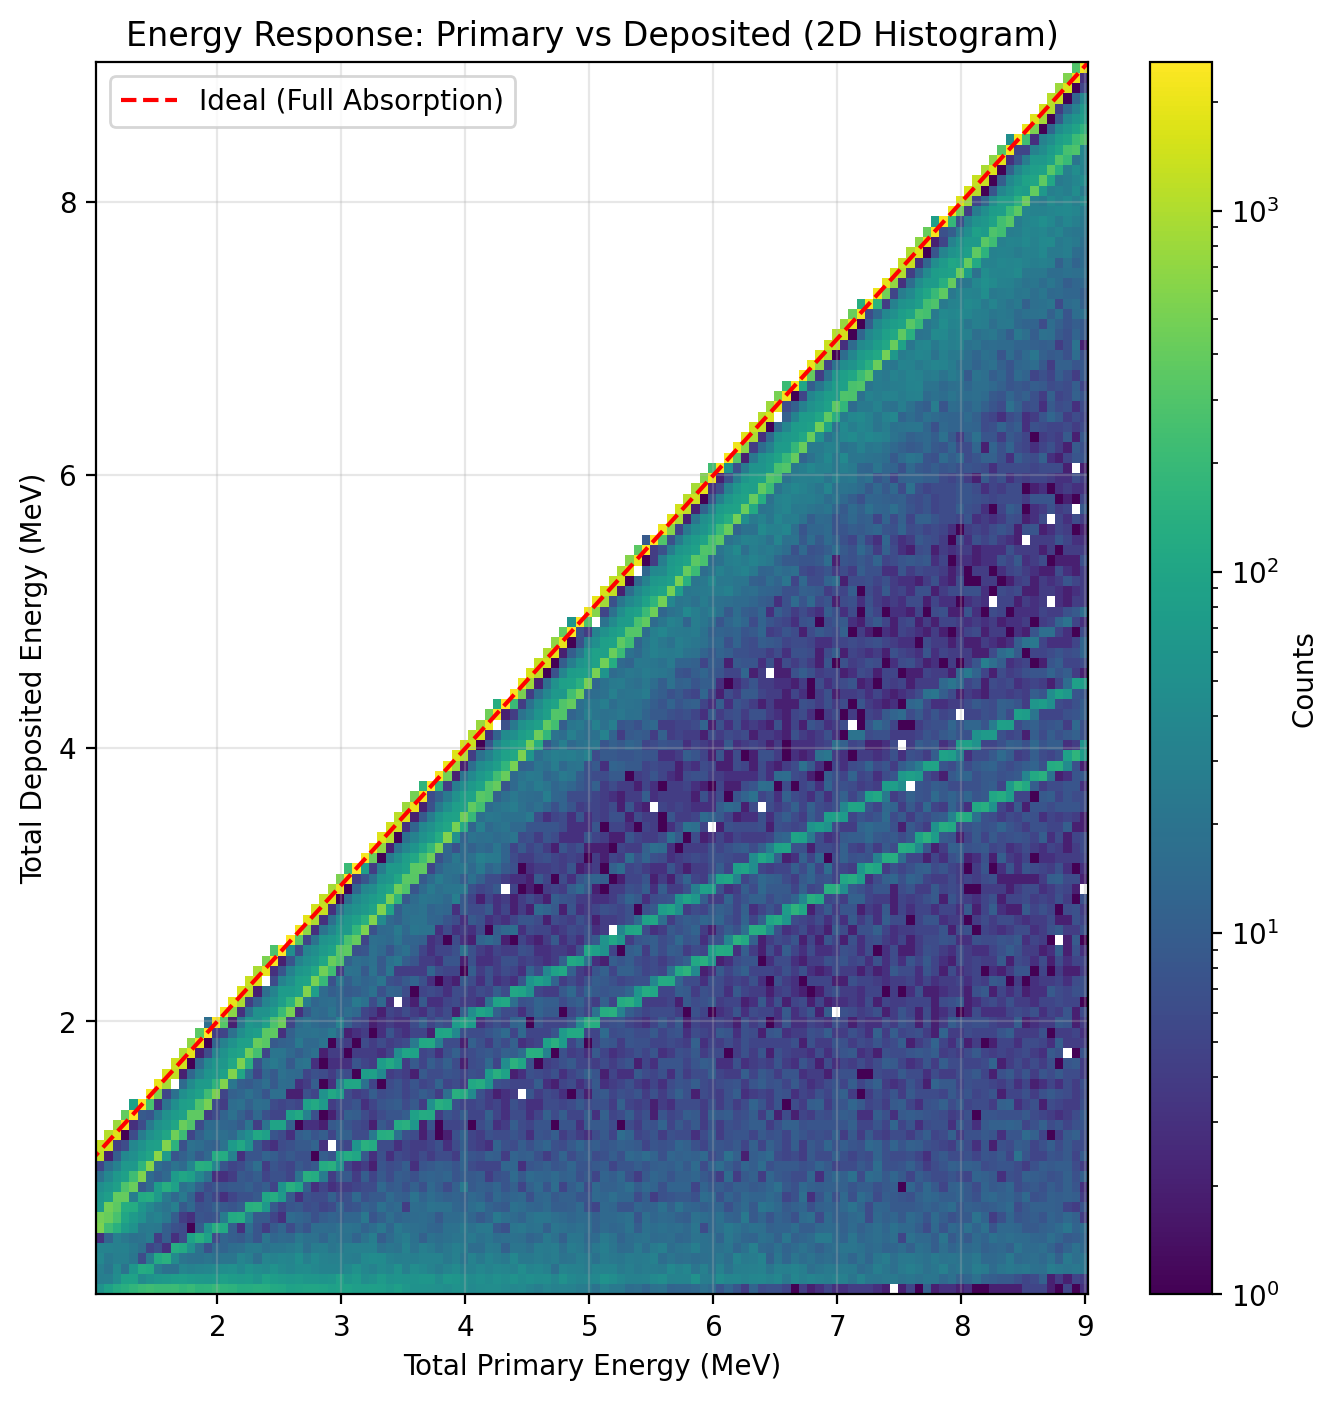

In [221]:
# 绘图 1: 能量响应二维直方图
plt.figure(figsize=(8, 8))
counts, xedges, yedges, image = plt.hist2d(
    df_energy_corr["total_primary_energy"],
    df_energy_corr["total_edep"],
    bins=(120, 120),
    norm=LogNorm(),
    cmap="viridis",
)
plt.colorbar(image, label="Counts")
# 绘制 y=x 参考线
max_e = max(df_energy_corr["total_primary_energy"].max(), df_energy_corr["total_edep"].max())
plt.plot([0, max_e], [0, max_e], "r--", label="Ideal (Full Absorption)")

plt.xlabel("Total Primary Energy (MeV)")
plt.ylabel("Total Deposited Energy (MeV)")
plt.title("Energy Response: Primary vs Deposited (2D Histogram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [224]:
df_hits
event_id_counts = df_hits["EventID"].value_counts().sort_index().rename("hit_count").to_frame()
event_id_counts[event_id_counts["hit_count"] > 6]

,hit_count
EventID,
1016,7
1256,8
1264,7
1696,7
1797,7
...,...
498649,7
499031,7
499205,8


In [225]:
df_hits[df_hits["EventID"] == 514]

,EventID,hit_idx,crystalID,edep,time,posX,posY,posZ,pdg,parentID,...,dirY,dirZ,kineticEnergy,processID,trackLength,ix,iy,iz,dEdx,particle_name
1061,514,0,60200,1.478435,0.00000,134.680202,-67.961152,-140.121692,-11,0,...,-0.394518,-0.823053,0.722326,0,4.263644,6,2,0,0.346754,Positron
1062,514,1,50200,0.529123,0.05722,117.731689,-66.177102,-140.080387,11,4,...,0.518329,0.194037,0.529123,2,0.745509,5,2,0,0.709748,Electron


In [226]:
np.sum(df_hits[df_hits["EventID"] == 514])

/home/wxy/anaconda3/envs/pyroot-kernel/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


EventID                      1028
hit_idx                         1
crystalID                  110400
edep                     2.007558
time                      0.05722
posX                   252.411891
posY                  -134.138254
posZ                  -280.202079
pdg                             0
parentID                        4
dirX                    -1.241459
dirY                     0.123811
dirZ                    -0.629017
kineticEnergy            1.251449
processID                       2
trackLength              5.009153
ix                             11
iy                              4
iz                              0
dEdx                     1.056502
particle_name    PositronElectron
dtype: object

###  击中数分布

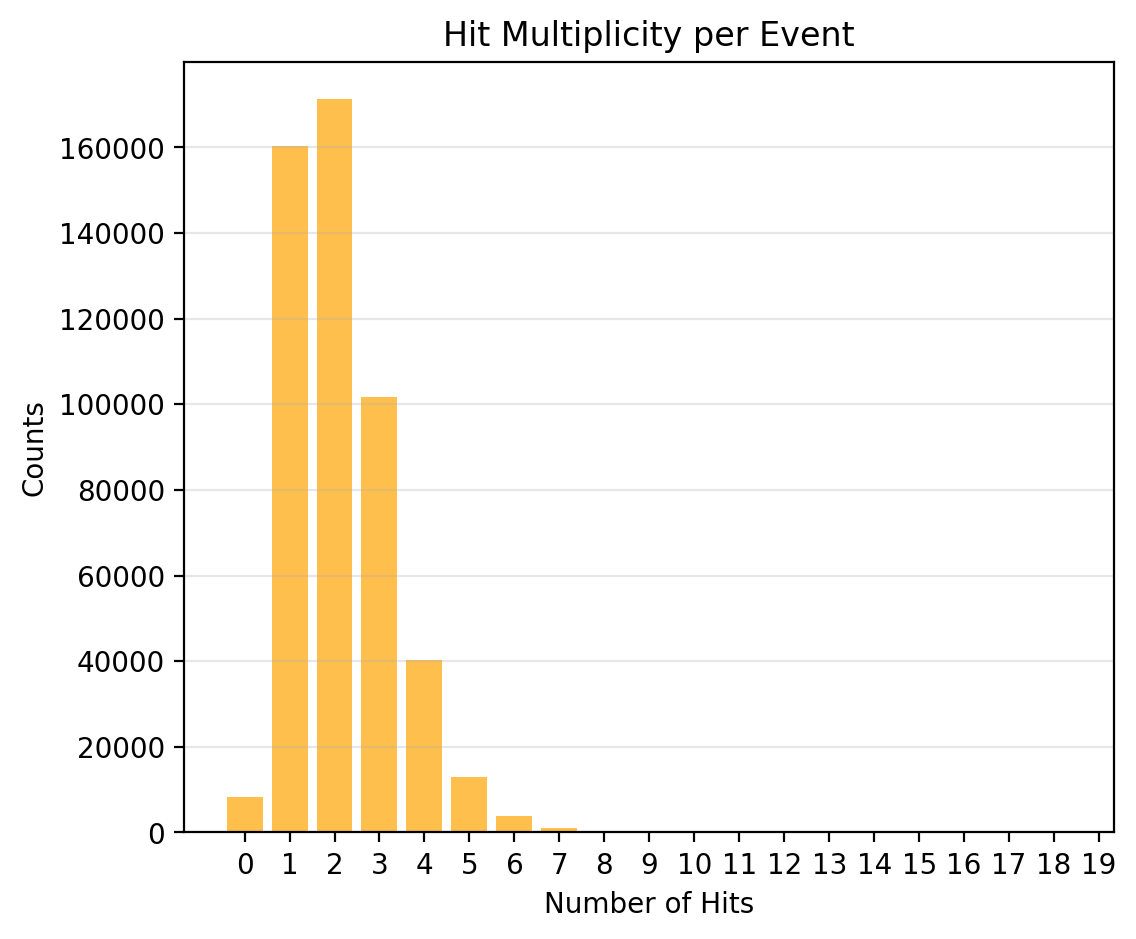

In [242]:
plt.figure(figsize=(6, 5))
plt.hist(data["HitCount"], bins=range(0, 20), align="left", rwidth=0.8, color="orange", alpha=0.7)
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.title("Hit Multiplicity per Event")
plt.xticks(range(0, 20))
plt.grid(True, axis="y", alpha=0.3)
plt.show()


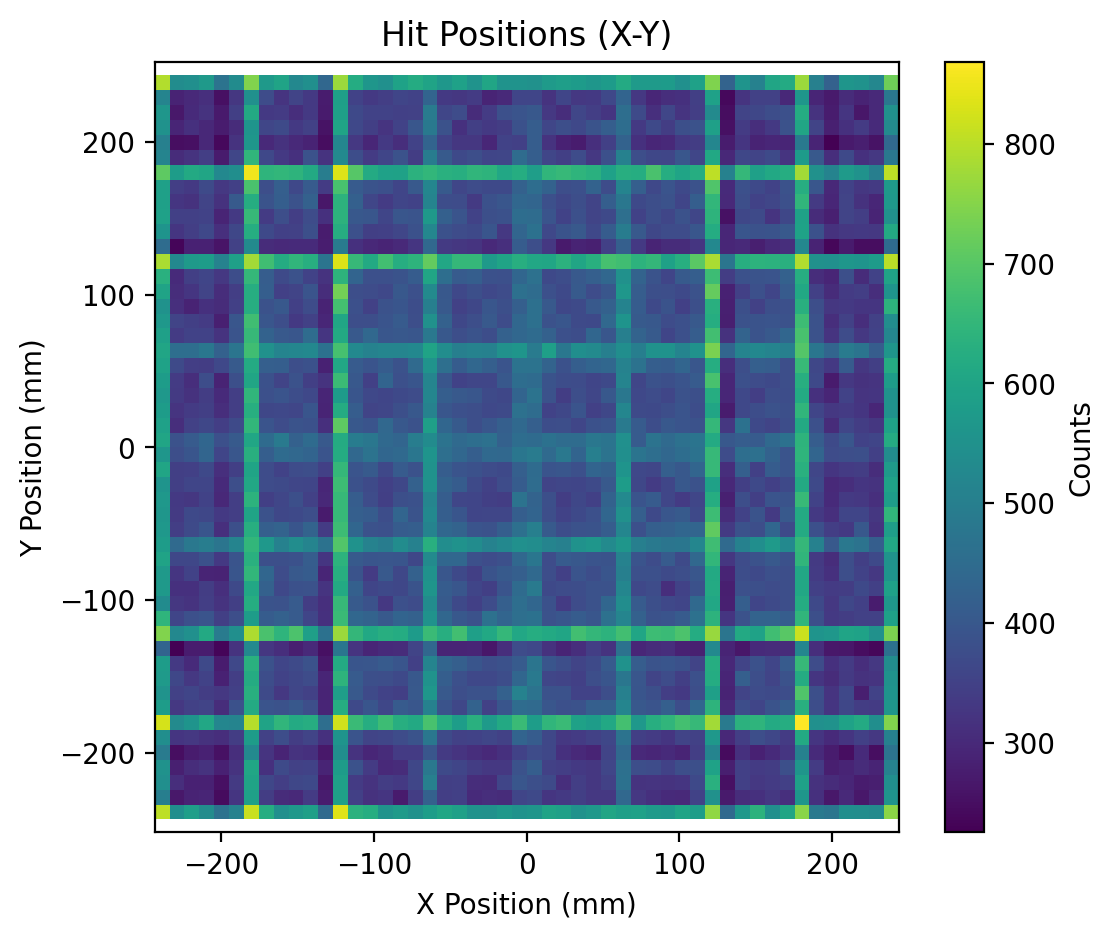

In [ ]:
# 3. 击中位置分布 (Hit Positions X-Y)
plt.figure(figsize=(6, 5))
plt.hist2d(flat_posX, flat_posY, bins=50, cmap="viridis", cmin=1)
plt.colorbar(label="Counts")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.title("Hit Positions (X-Y)")
plt.axis("equal")
plt.show()


### 物理过程分布

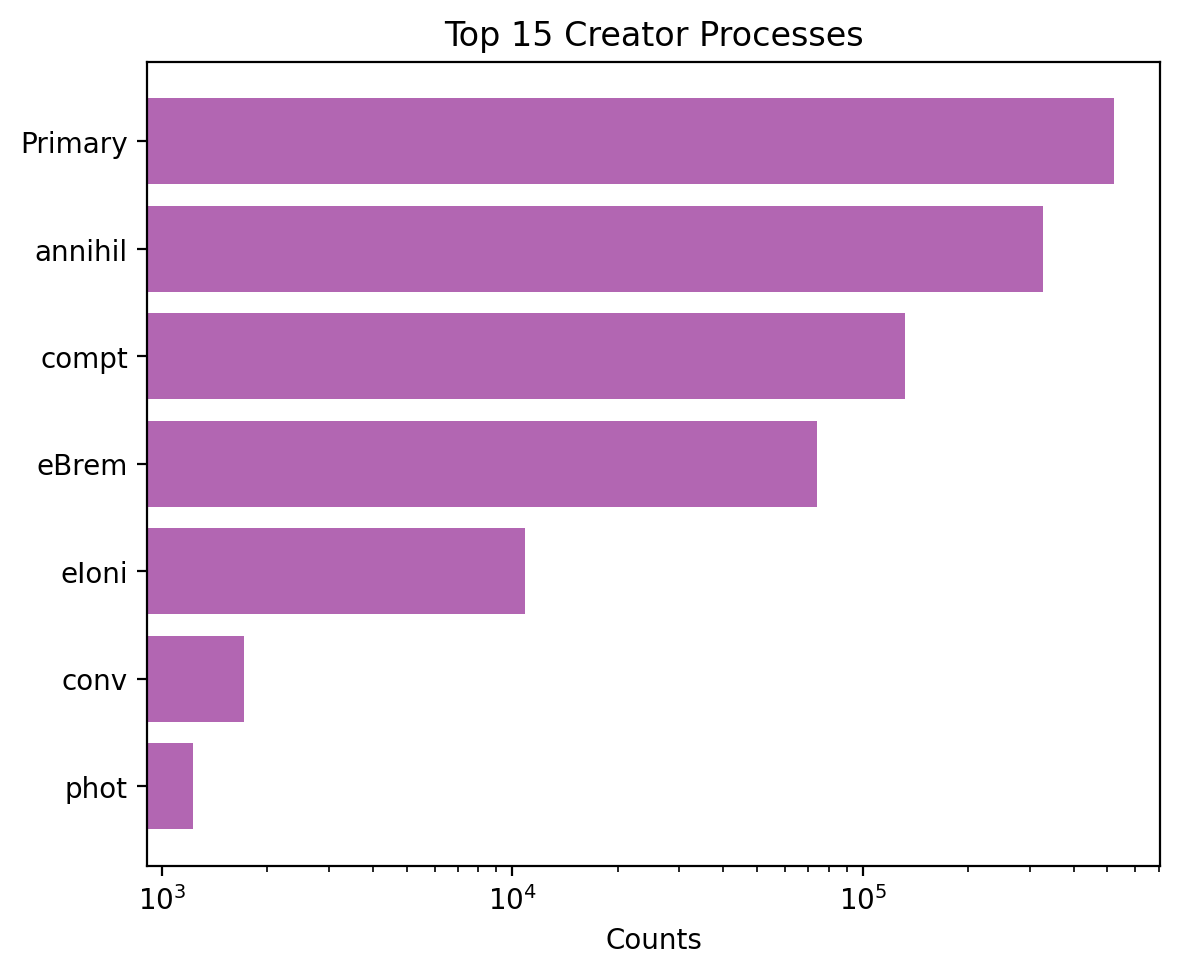

In [ ]:
unique_procs, proc_counts = np.unique(flat_process, return_counts=True)
proc_labels = [process_map.get(pid, f"ID {pid}") for pid in unique_procs]

sorted_indices = np.argsort(proc_counts)[::-1]
sorted_counts = proc_counts[sorted_indices]
sorted_labels = np.array(proc_labels)[sorted_indices]

top_n = 15
if len(sorted_counts) > top_n:
    sorted_counts = sorted_counts[:top_n]
    sorted_labels = sorted_labels[:top_n]


plt.figure(figsize=(6, 5))
plt.barh(range(len(sorted_counts)), sorted_counts, color="purple", alpha=0.6)
plt.yticks(range(len(sorted_counts)), sorted_labels)
plt.xlabel("Counts")
plt.title(f"Top {top_n} Creator Processes")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.tight_layout()
plt.show()


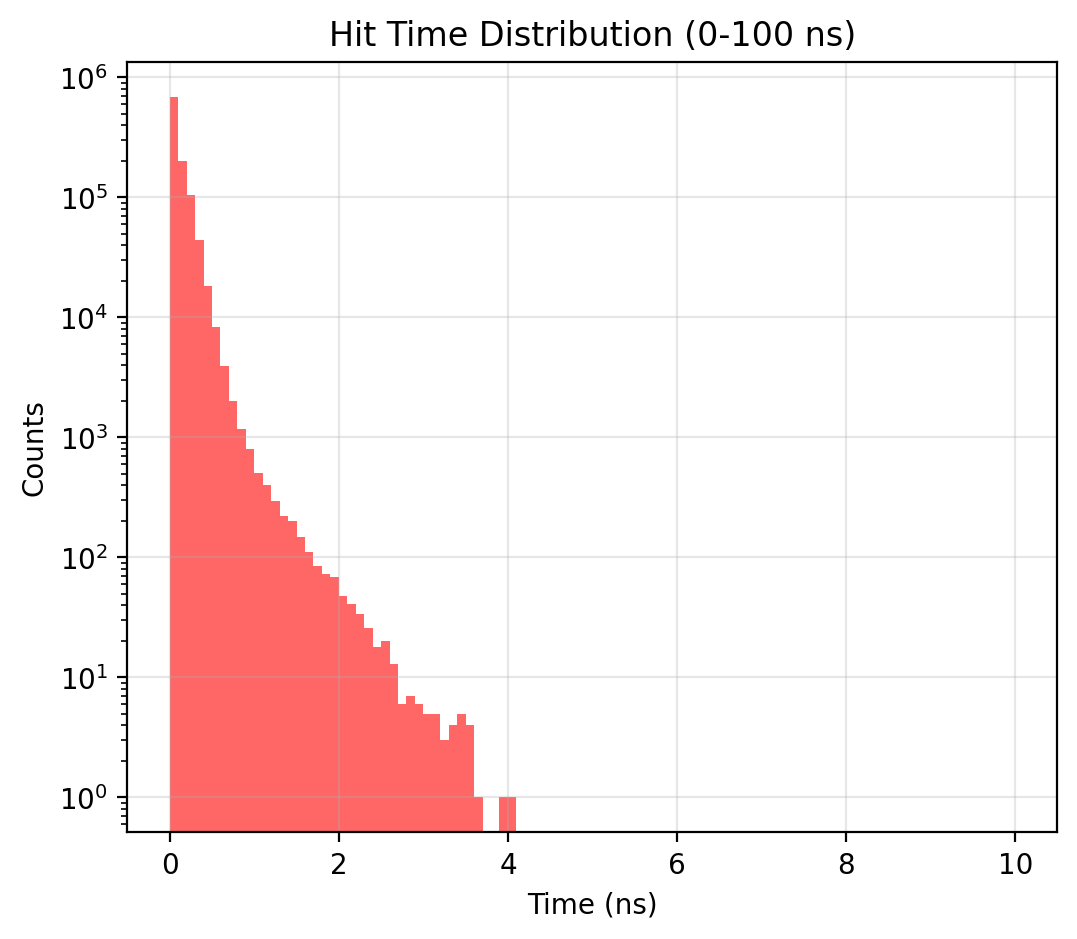

In [ ]:
plt.figure(figsize=(6, 5))
plt.hist(flat_time, bins=100, range=(0, 10), color="red", alpha=0.6)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.title("Hit Time Distribution (0-100 ns)")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

# 每个事件的能量沉积与物理过程贡献分析

### Event Level Edep 

分别画出事件的总能量沉积, 和分粒子的能量沉积


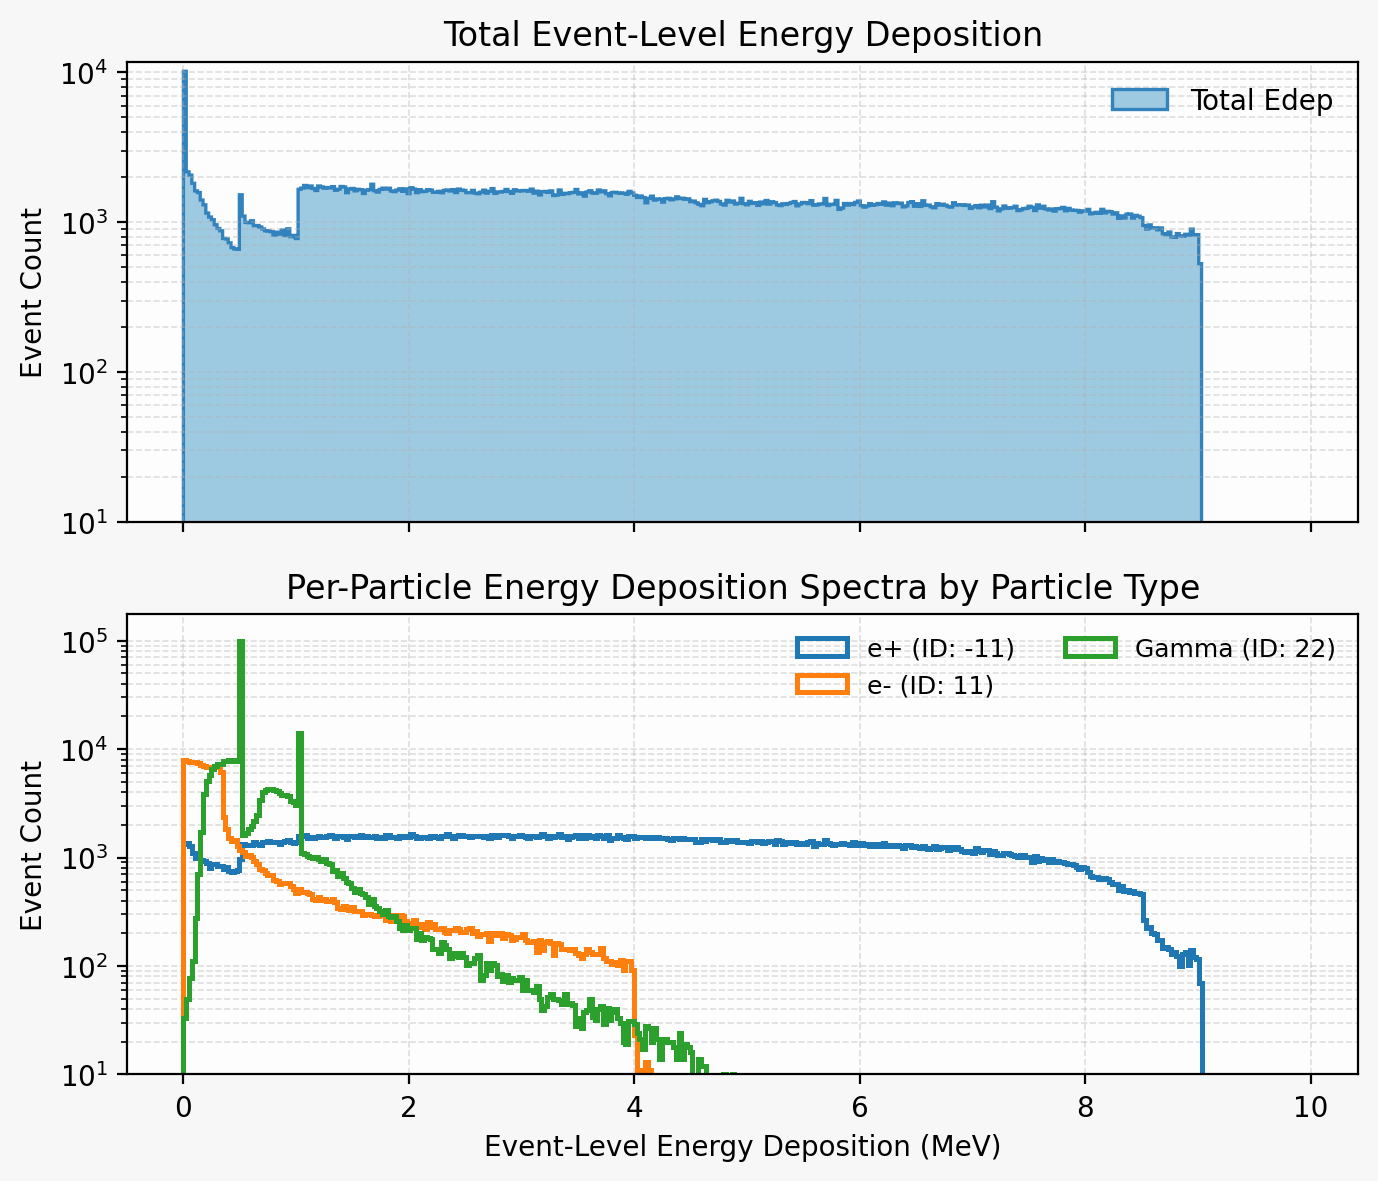

In [228]:
%config InlineBackend.figure_format = "retina"

unique_pdgs = np.unique(flat_pdg)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}

max_range = float(np.max(data["TotalEdep"])) * 1.1

fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True, facecolor="#f7f7f7")
for ax in axes:
    ax.set_facecolor("#fdfdfd")
    ax.set_ylabel("Event Count")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.4)

# 上图：总能量沉积谱
axes[0].hist(
    data["TotalEdep"],
    bins=400,
    range=(0, max_range),
    histtype="stepfilled",
    color="#9ecae1",
    edgecolor="#3182bd",
    linewidth=1.2,
    label="Total Edep",
)
axes[0].set_title("Total Event-Level Energy Deposition")
axes[0].legend(loc="upper right", frameon=False)
axes[0].set_ylim(10, None)

# 下图：按粒子类型分类的能量沉积谱
for pid in unique_pdgs:
    particle_hits = df_hits[df_hits["pdg"] == pid]
    if particle_hits.empty:
        continue
    particle_event_edep = particle_hits.groupby("EventID")["edep"].sum()
    label = f"{pdg_names.get(pid, f'PDG {pid}')} (ID: {pid})"
    axes[1].hist(
        particle_event_edep,
        bins=400,
        range=(0, max_range),
        histtype="step",
        linewidth=1.8,
        label=label,
    )

axes[1].set_xlabel("Event-Level Energy Deposition (MeV)")
axes[1].set_title("Per-Particle Energy Deposition Spectra by Particle Type")
axes[1].legend(loc="upper right", fontsize=9, ncol=2, frameon=False)
axes[1].set_ylim(10, None)

plt.tight_layout()
plt.show()

### 物理过程的能量贡献占比


In [255]:
data[4]

<Record {EventID: 4, TotalEdep: 5.85, ...} type='{EventID: int32, TotalEdep...'>

In [257]:
# Awkward Array (ak) 基础操作演示
# Awkward Array 专门用于处理不规则数据（如每个事件有不同数量的 Hit）

import awkward as ak

print(f"数据包含的字段: {data.fields}")

# 1. 访问 Jagged Array (参差数组/变长数组)
# CrystalEdep 是每个事件中所有 Crystal 的沉积能量列表
crystal_edeps = data["CrystalEdep"]
print(f"\n--- Jagged Array 示例 (前3个事件) ---")
print(crystal_edeps[:3])

# 2. 聚合操作 (axis=1 表示在事件内部进行操作)
# 计算每个事件的 Hit 数量
num_hits = ak.num(crystal_edeps, axis=1)
# 计算每个事件的总能量 (验证 TotalEdep)
sum_edep = ak.sum(crystal_edeps, axis=1)

print(f"\n--- 聚合操作 ---")
print(f"Hit 数量 (前5个): {num_hits[:5]}")
print(f"求和能量 (前5个): {sum_edep[:5]}")

# 3. 过滤 (Masking)
# 3.1 事件级过滤: 选择 Hit 数 > 5 的事件
complex_events = data[num_hits > 5]
print(f"\n--- 过滤 ---")
print(f"复杂事件数 (Hits > 5): {len(complex_events)}")

# 3.2 Hit 级过滤: 仅保留能量 > 0.1 MeV 的 Hit
# 注意：这会保留事件结构，但每个事件中的 Hit 列表会变短
hard_hits = crystal_edeps[crystal_edeps > 0.1]
print(f"硬 Hit (>0.1 MeV) 结构 (前3个事件):\n{hard_hits[:3]}")

# 4. 展平 (Flatten)
# 将所有事件的 Hit 合并成一个大的一维数组 (常用于画总体分布)
flat_edeps = ak.flatten(crystal_edeps)
print(f"\n--- 展平 ---")
print(f"所有 Hit 展平后的长度: {len(flat_edeps)}")

数据包含的字段: ['EventID', 'TotalEdep', 'HitCount', 'CrystalID', 'CrystalEdep', 'CrystalTime', 'CrystalPosX', 'CrystalPosY', 'CrystalPosZ', 'CrystalPDG', 'CrystalParentID', 'CrystalDirX', 'CrystalDirY', 'CrystalDirZ', 'CrystalKineticEnergy', 'CrystalProcessID', 'CrystalTrackLength', 'PrimaryPDG', 'PrimaryEnergy', 'PrimaryPosX', 'PrimaryPosY', 'PrimaryPosZ', 'PrimaryDirX', 'PrimaryDirY', 'PrimaryDirZ']

--- Jagged Array 示例 (前3个事件) ---
[[0.246], [5.93], [2.85, 0.511]]

--- 聚合操作 ---
Hit 数量 (前5个): [1, 1, 2, 4, 5]
求和能量 (前5个): [0.246, 5.93, 3.36, 5.97, 5.85]

--- 过滤 ---
复杂事件数 (Hits > 5): 5272
硬 Hit (>0.1 MeV) 结构 (前3个事件):
[[0.246], [5.93], [2.85, 0.511]]

--- 展平 ---
所有 Hit 展平后的长度: 1067393


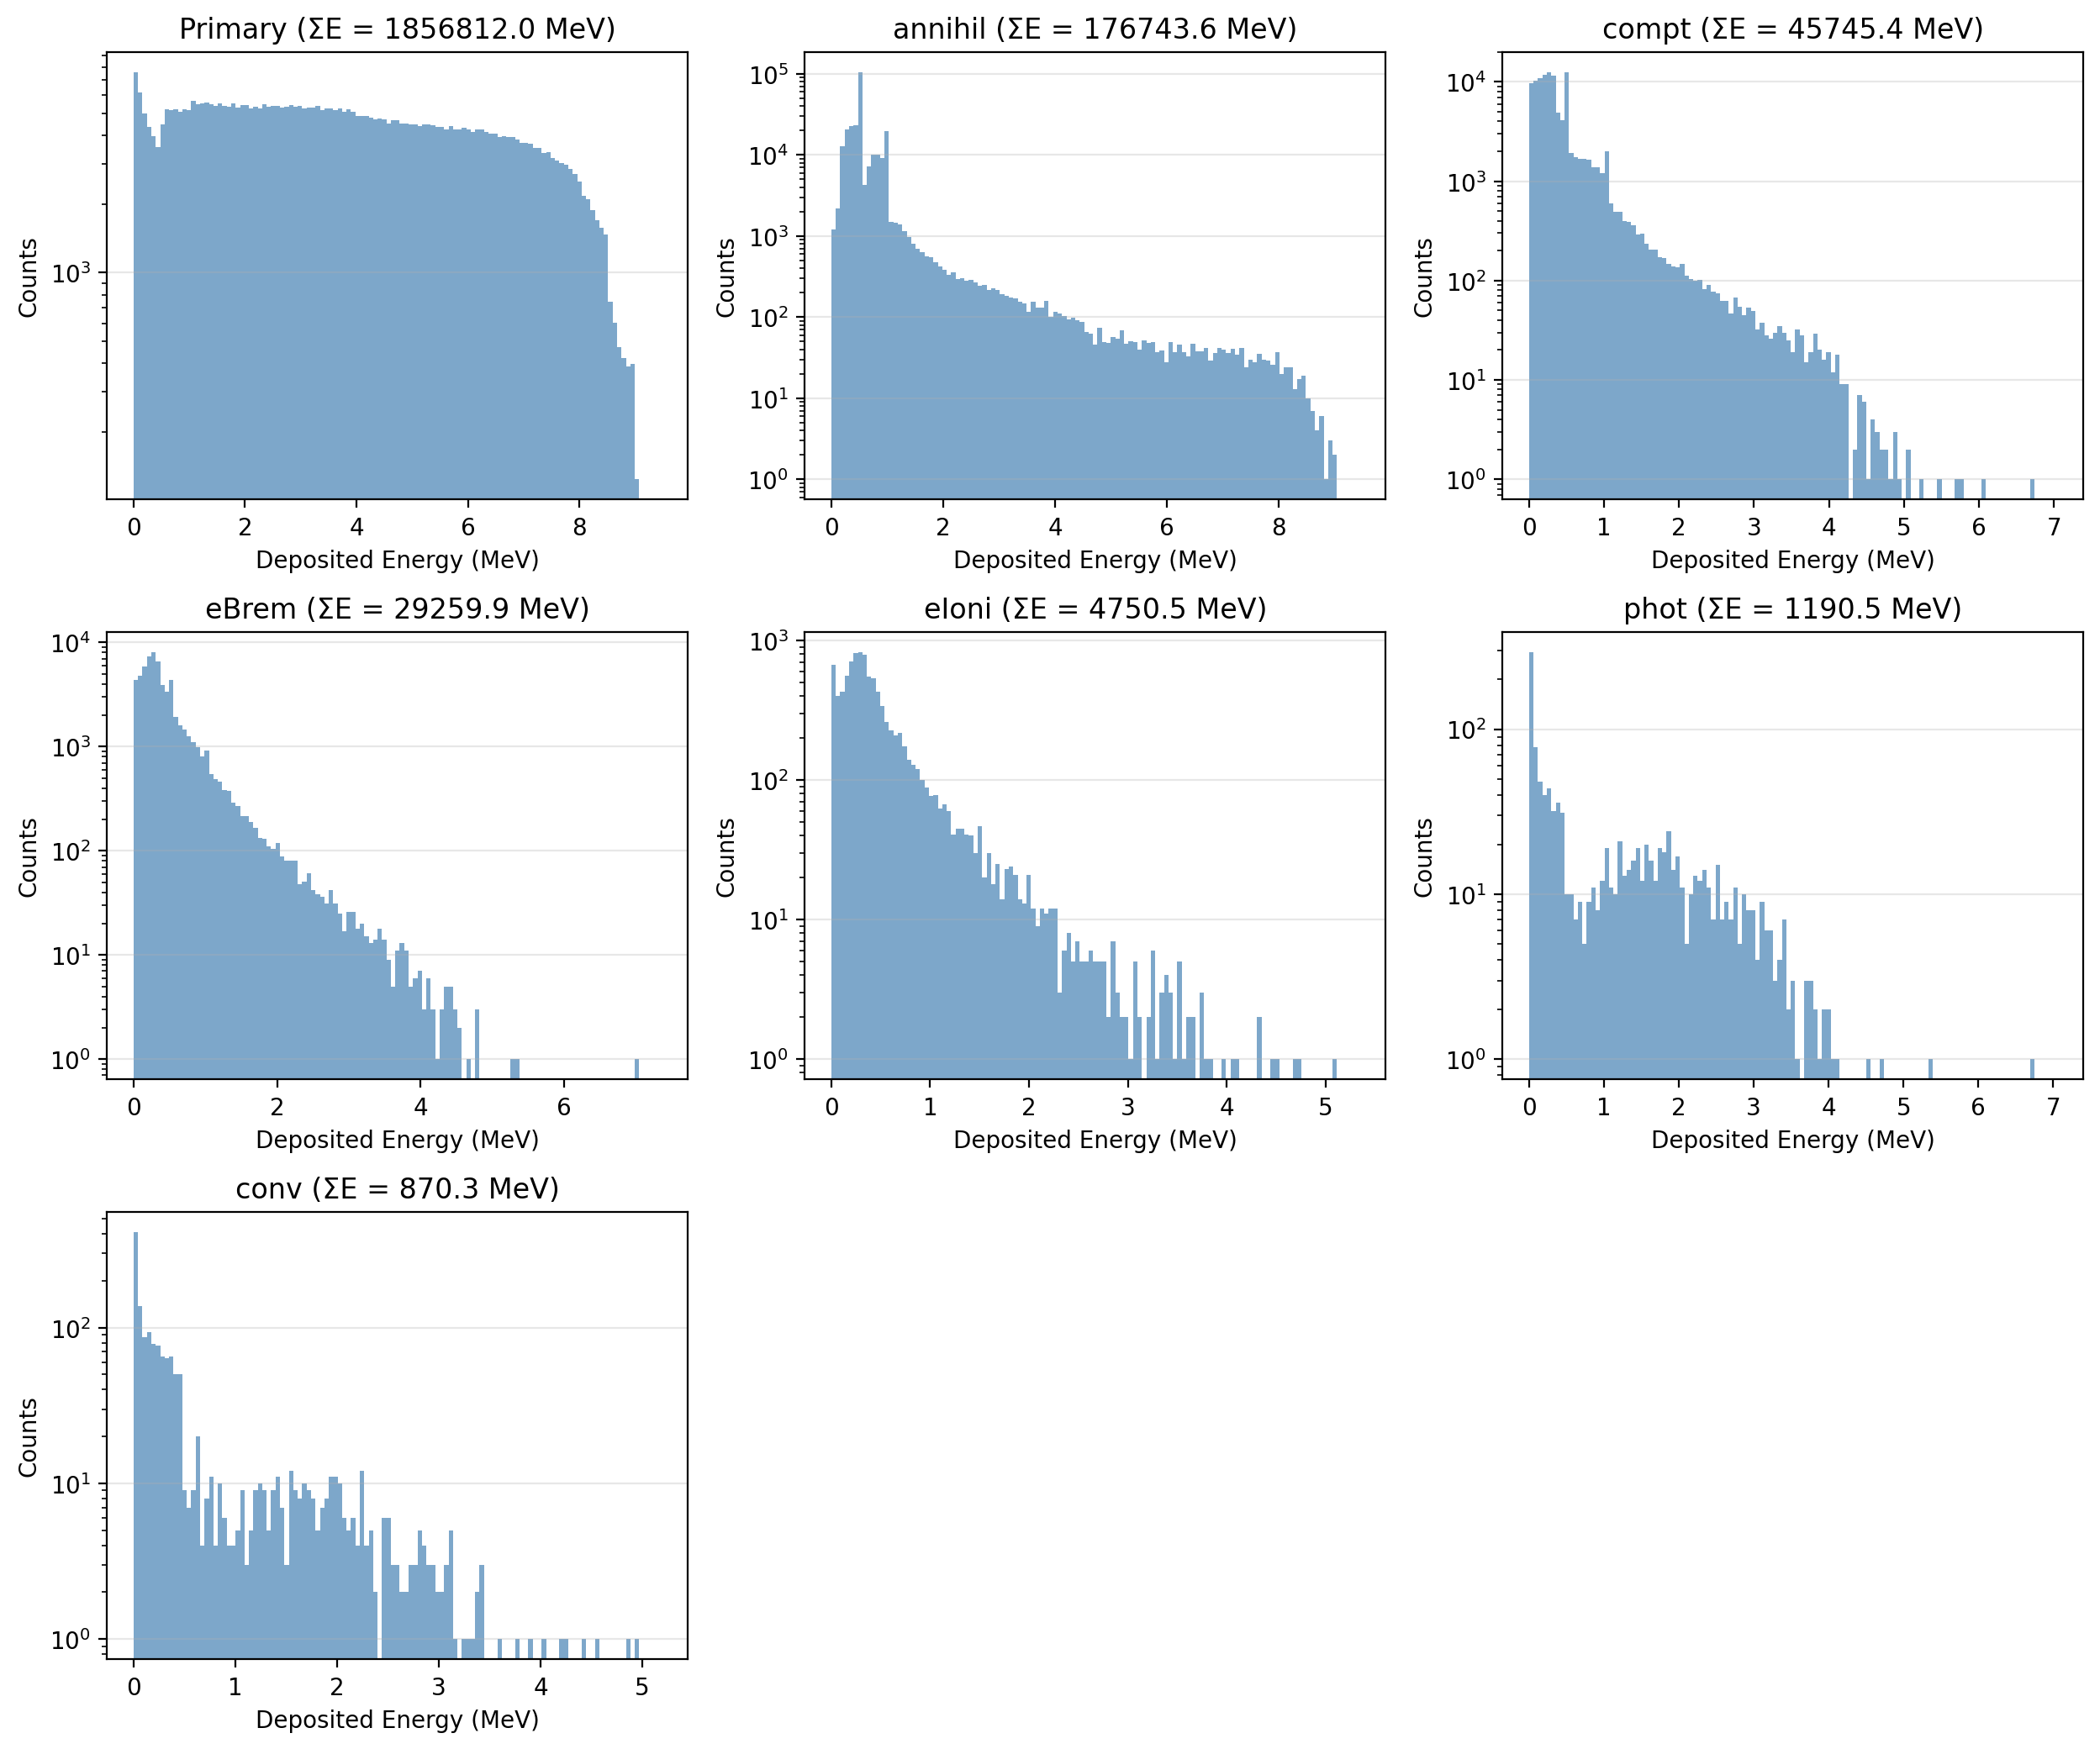

In [251]:
process_list = total_by_process.index.tolist()
n_cols = 3
n_rows = int(np.ceil(len(process_list) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False)
axes = axes.flatten()

for ax, process in zip(axes, process_list):
    values = process_contribution.loc[process_contribution["process_name"] == process, "edep_by_process"]
    bins = np.linspace(0, values.max() * 1.05, 120)
    ax.hist(values, bins=bins, color="steelblue", alpha=0.7)
    ax.set_title(f"{process} (ΣE = {values.sum():.1f} MeV)")
    ax.set_xlabel("Deposited Energy (MeV)")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.grid(True, axis="y", alpha=0.3)

for ax in axes[len(process_list) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# filepath:
# ...existing code...

# ==========================================
# 区分电子来源：是否由正电子产生
# ==========================================

# 1. 构建 TrackID -> PDG 的映射表
# 我们需要知道每个 parentID 对应的是什么粒子
# 注意：这里假设父粒子至少在探测器中留下了一个 Hit。如果父粒子完全没有沉积能量，这种方法会漏掉（通常带电粒子都会有 Hit）
track_info = df_hits[["EventID", "trackID", "pdg"]].drop_duplicates()

# 2. 将 Hit 数据与 Track 信息合并，以获取父粒子的 PDG
# left_on: 当前 Hit 的 parentID
# right_on: Track 表的 trackID
df_hits_with_parent = pd.merge(df_hits, track_info, left_on=["EventID", "parentID"], right_on=["EventID", "trackID"], how="left", suffixes=("", "_parent"))

# 3. 提取正电子的能量沉积 (按事件)
pos_edep = df_hits_with_parent[df_hits_with_parent["pdg"] == -11].groupby("EventID")["edep"].sum().rename("Positron_Edep")

# 4. 提取 "正电子产生的电子" (Daughter Electrons)
# 条件: 当前是电子 (11) AND 父粒子是正电子 (-11)
mask_e_from_pos = (df_hits_with_parent["pdg"] == 11) & (df_hits_with_parent["pdg_parent"] == -11)
e_from_pos_edep = df_hits_with_parent[mask_e_from_pos].groupby("EventID")["edep"].sum().rename("E_from_Pos_Edep")

# 5. 提取 "其他电子" (Independent Electrons)
# 条件: 当前是电子 (11) AND (父粒子不是正电子 OR 是初级粒子)
mask_e_other = (df_hits_with_parent["pdg"] == 11) & (df_hits_with_parent["pdg_parent"] != -11)
e_other_edep = df_hits_with_parent[mask_e_other].groupby("EventID")["edep"].sum().rename("E_Other_Edep")

# 6. 合并所有数据
df_corr_detailed = pd.concat([pos_edep, e_from_pos_edep, e_other_edep], axis=1).fillna(0)

print("电子来源详细分析:")
print(f"总事件数: {len(df_corr_detailed)}")
print(f"含有正电子的事件: {(df_corr_detailed['Positron_Edep'] > 0).sum()}")
print(f"含有正电子衍生电子的事件: {(df_corr_detailed['E_from_Pos_Edep'] > 0).sum()}")

# ==========================================
# 可视化
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 图 1: 正电子能量 vs 正电子产生的次级电子能量
# 物理意义: 正电子损失能量产生 delta 射线或电离电子的相关性
mask1 = (df_corr_detailed["Positron_Edep"] > 0) & (df_corr_detailed["E_from_Pos_Edep"] > 0)
if mask1.sum() > 0:
    h1 = axes[0].hist2d(df_corr_detailed[mask1]["Positron_Edep"], df_corr_detailed[mask1]["E_from_Pos_Edep"], bins=50, norm=LogNorm(), cmap="inferno")
    plt.colorbar(h1[3], ax=axes[0], label="Counts")
    axes[0].set_xlabel("Positron Edep (MeV)")
    axes[0].set_ylabel("Secondary Electron Edep (from e+)")
    axes[0].set_title("Correlation: Positron vs. Its Daughter Electrons")
else:
    axes[0].text(0.5, 0.5, "No Data for e+ -> e-", ha="center")

# 图 2: 正电子能量 vs 其他电子能量
# 物理意义: 检查是否是独立的两个粒子（如对产生出来的 e+ 和 e-）
mask2 = (df_corr_detailed["Positron_Edep"] > 0) & (df_corr_detailed["E_Other_Edep"] > 0)
if mask2.sum() > 0:
    h2 = axes[1].hist2d(df_corr_detailed[mask2]["Positron_Edep"], df_corr_detailed[mask2]["E_Other_Edep"], bins=50, norm=LogNorm(), cmap="viridis")
    plt.colorbar(h2[3], ax=axes[1], label="Counts")
    axes[1].set_xlabel("Positron Edep (MeV)")
    axes[1].set_ylabel("Independent Electron Edep")
    axes[1].set_title("Correlation: Positron vs. Independent Electrons")

    # 如果是对产生 (Pair Production)，通常 e+ 和 e- 能量会有某种负相关（总能量守恒）
    # 画一条简单的参考线 (假设总能量是某个典型值，例如入射光子能量)
    # max_e = df_corr_detailed[mask2].max().max()
    # axes[1].plot([0, max_e], [max_e, 0], 'r--', alpha=0.5, label="Energy Conservation Trend")

plt.tight_layout()
plt.show()

KeyError: "['trackID'] not in index"

: 

: 

: 

: 

: 

### Primary 过程的物理含义分析

在 Geant4 中，`Primary` (processID=0) 并不代表某个具体的物理过程，而是标记**初级粒子**直接造成的能量沉积。

初级粒子损失能量的主要机制取决于粒子类型：
- **电子/正电子 (e⁻/e⁺)**: 主要通过**电离损失** (ionization) 和**韧致辐射** (bremsstrahlung)
- **光子 (γ)**: 通过**光电效应** (photoelectric)、**康普顿散射** (Compton) 或**对产生** (pair production)
- **重带电粒子**: 主要通过电离损失



### TrackLength 的分布

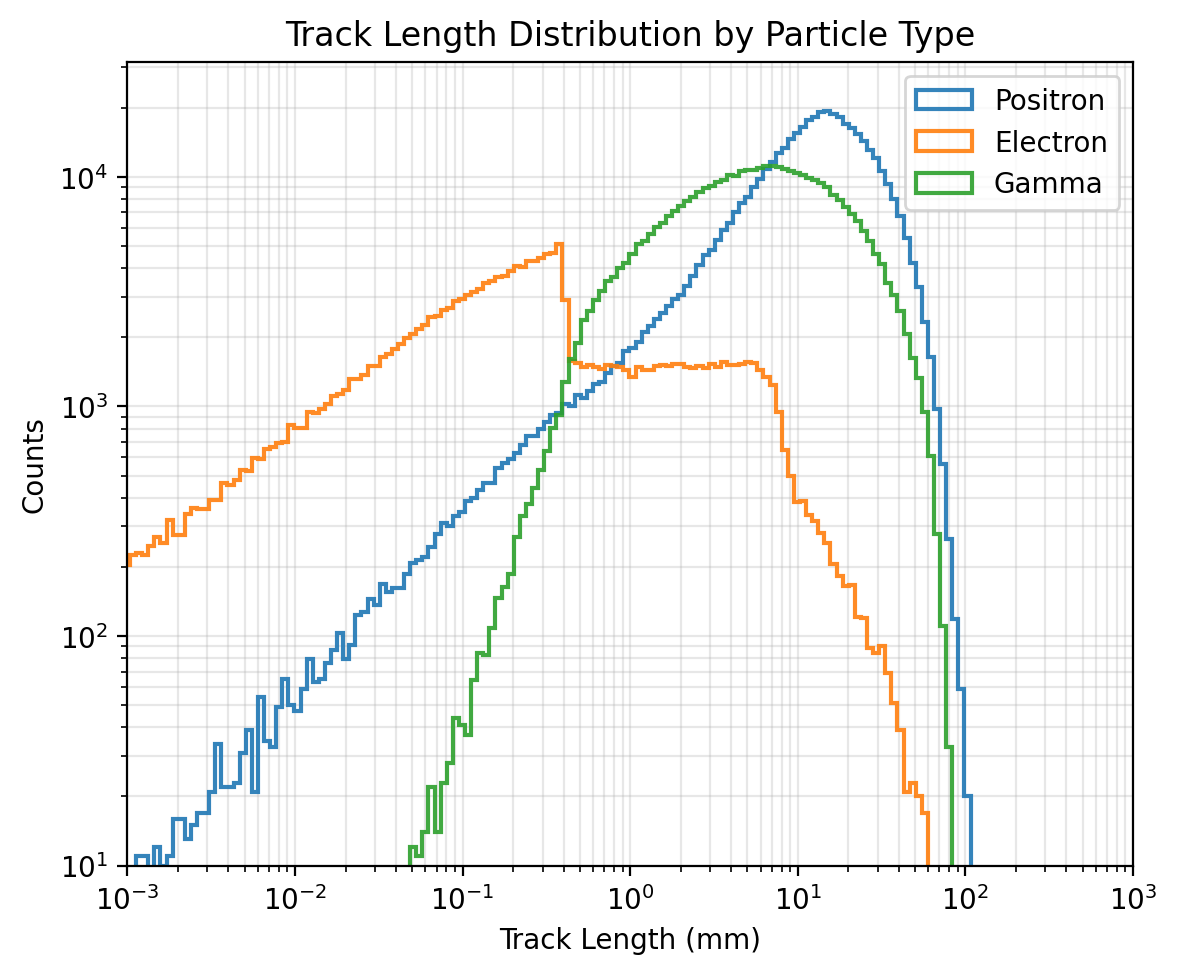

In [230]:
# 电子与正电子反应的 track length 分布
target_pids = [-11, 11, 22, 13, -13, 2112, 2212]
track_length_data = {}
for pid in target_pids:
    tracks = df_hits.loc[(df_hits["pdg"] == pid) & (df_hits["trackLength"] > 0), "trackLength"]
    if not tracks.empty:
        track_length_data[pid] = tracks

if track_length_data:
    min_track = min(series.min() for series in track_length_data.values())
    max_track = max(series.max() for series in track_length_data.values())
    common_bins = np.logspace(np.log10(min_track), np.log10(max_track), 200)

    plt.figure(figsize=(6, 5))
    colors = plt.cm.tab10(range(len(track_length_data)))
    for (pid, series), color in zip(track_length_data.items(), colors):
        label = pdg_name_map.get(pid, f"PDG {pid}")
        plt.hist(series, bins=common_bins, histtype="step", linewidth=1.5, alpha=0.9, color=color, label=label)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Track Length (mm)")
    plt.ylabel("Counts")
    plt.xlim(1e-3, 1e3)
    plt.ylim(10, None)
    plt.title("Track Length Distribution by Particle Type")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()

### gamma 生成的过程

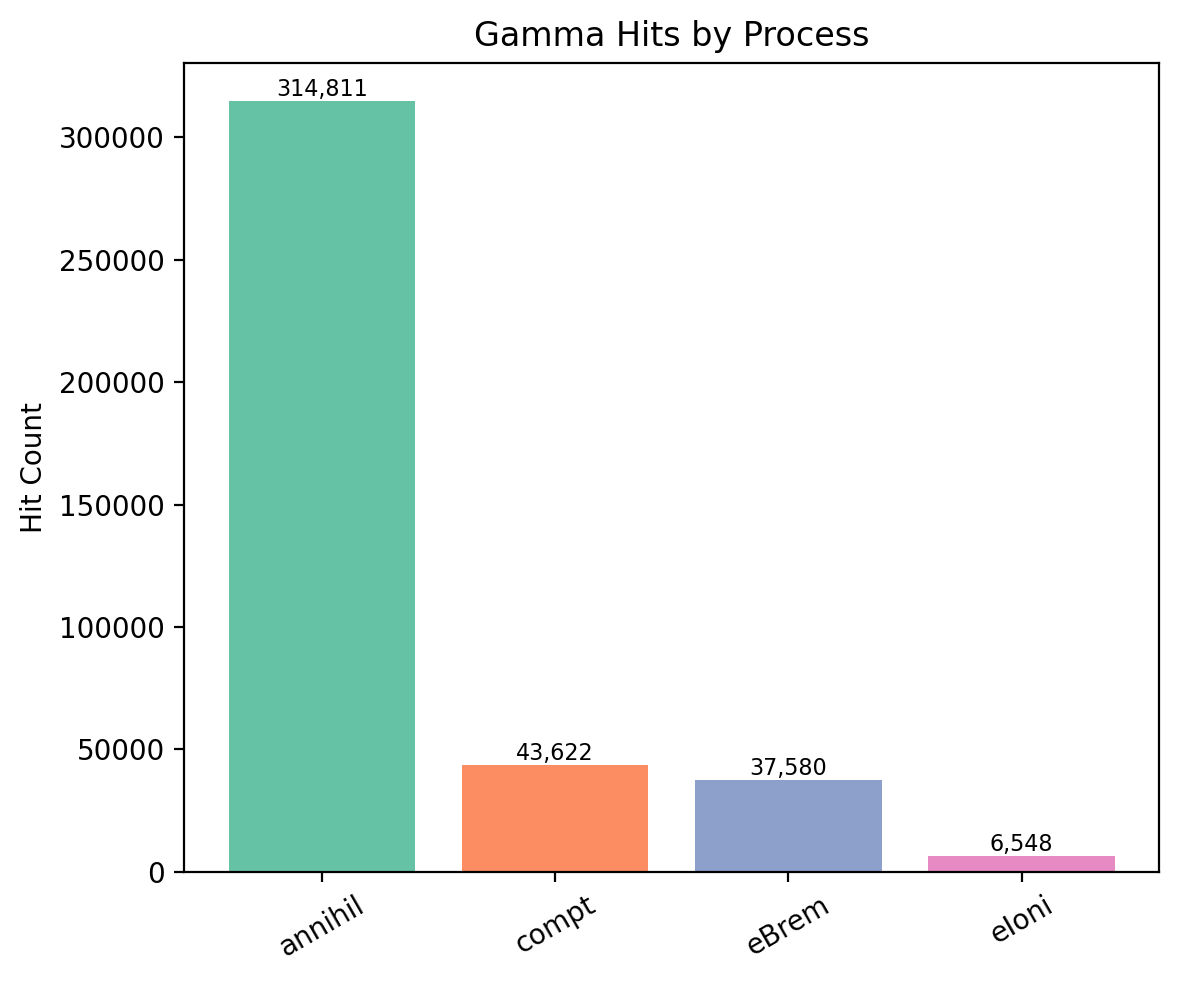

In [231]:
# 可视化伽马产生过程统计
fig, axes = plt.subplots(1, figsize=(6, 5))
axes = [axes]
# 1. 各过程 Hit 数
colors = plt.cm.Set2(range(len(gamma_process_summary)))
axes[0].bar(process_names := gamma_process_summary.index, gamma_process_summary["hit_count"], color=colors)
axes[0].set_ylabel("Hit Count")
axes[0].set_title("Gamma Hits by Process")
axes[0].tick_params(axis="x", rotation=30)
for i, v in enumerate(gamma_process_summary["hit_count"]):
    axes[0].text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=8)

# # 2. 各过程沉积能量
# axes[1].bar(process_names, gamma_process_summary["total_edep"], color=colors)
# axes[1].set_ylabel("Total Deposited Energy (MeV)")
# axes[1].set_title("Deposited Energy by Process")
# axes[1].tick_params(axis="x", rotation=30)
# for i, v in enumerate(gamma_process_summary["total_edep"]):
#     axes[1].text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)

# # 3. Primary / Secondary 分解（按计数）
# origin_cols = origin_breakdown.columns
# bottom = np.zeros(len(origin_breakdown))
# for col in origin_cols:
#     axes[2].bar(process_names, origin_breakdown[col], bottom=bottom, label=col)
#     bottom += origin_breakdown[col].values
# axes[2].set_ylabel("Hit Count")
# axes[2].set_title("Origin Breakdown per Process")
# axes[2].tick_params(axis="x", rotation=30)
# axes[2].legend(title="Origin")

plt.tight_layout()
plt.show()

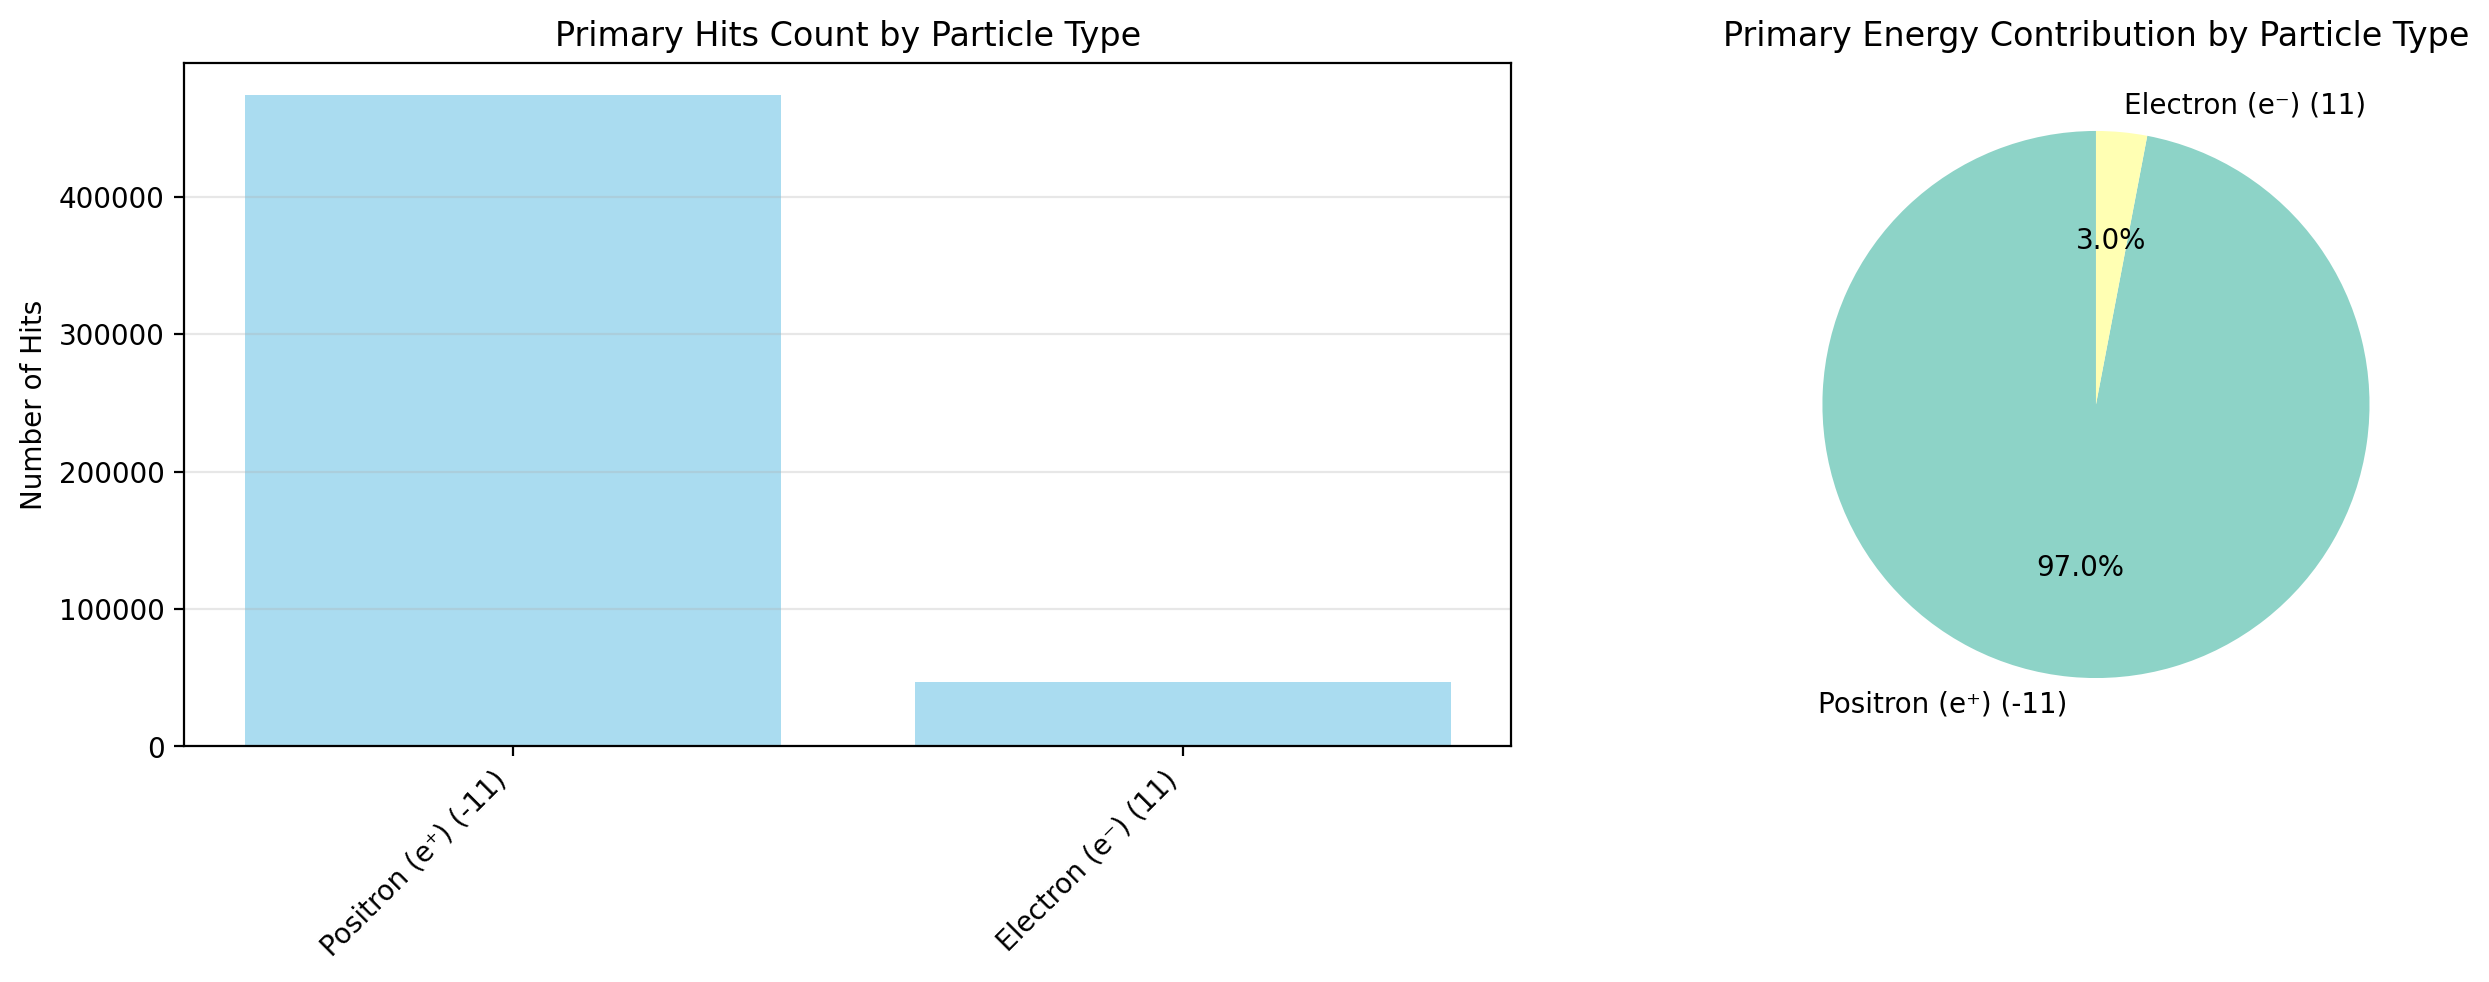

In [232]:
# 6. 可视化 Primary 过程中粒子类型的贡献
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图: Hit 数量分布
particle_counts = primary_by_pdg["Hit_Count"].sort_values(ascending=False)
ax1.bar(range(len(particle_counts)), particle_counts.values, color="skyblue", alpha=0.7)
ax1.set_xticks(range(len(particle_counts)))
ax1.set_xticklabels(particle_counts.index, rotation=45, ha="right")
ax1.set_ylabel("Number of Hits")
ax1.set_title("Primary Hits Count by Particle Type")
ax1.grid(True, axis="y", alpha=0.3)

# 右图: 能量贡献饼图
energy_contrib = primary_by_pdg["Total_Energy (MeV)"].sort_values(ascending=False)
colors = plt.cm.Set3(range(len(energy_contrib)))
ax2.pie(energy_contrib, labels=energy_contrib.index, autopct="%1.1f%%", startangle=90, colors=colors)
ax2.set_title("Primary Energy Contribution by Particle Type")

plt.tight_layout()
plt.show()

# 基于事件级别的粒子分析

接下来我们按事件(Event)为单位，分析每个事件中不同粒子的贡献，包括：
- 不同粒子类型的能量沉积
- 不同粒子的Hit数量
- 径迹长度统计
- 粒子能谱分析

In [233]:
# 1. 计算每个事件中不同粒子类型的能量沉积
# 为 df_hits 添加粒子名称列
pdg_name_map = {22: "Gamma", 11: "Electron", -11: "Positron", 13: "Muon-", -13: "Muon+", 2112: "Neutron", 2212: "Proton"}
df_hits["particle_name"] = df_hits["pdg"].map(lambda x: pdg_name_map.get(x, f"PDG_{x}"))

# 按事件和粒子类型分组统计
event_particle_stats = (
    df_hits.groupby(["EventID", "particle_name"])
    .agg({
        "edep": ["sum", "mean", "count"],  # 总能量、平均能量、Hit数
        "kineticEnergy": ["mean", "max", "min"],  # 动能统计
    })
    .reset_index()
)

# 简化列名
event_particle_stats.columns = ["EventID", "Particle", "Total_Edep", "Mean_Edep", "Hit_Count", "Mean_KE", "Max_KE", "Min_KE"]

print("事件-粒子级别统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n数据形状: {event_particle_stats.shape}")
print(f"涉及的粒子类型: {event_particle_stats['Particle'].unique()}")

事件-粒子级别统计 (前20行):
    EventID  Particle  Total_Edep  Mean_Edep  Hit_Count   Mean_KE    Max_KE  \
0         0  Electron    0.246478   0.246478          1  0.331854  0.331854   
1         1  Positron    5.926113   5.926113          1  2.568682  2.568682   
2         2     Gamma    0.510999   0.510999          1  0.108472  0.108472   
3         2  Positron    2.846352   2.846352          1  1.167677  1.167677   
4         3  Electron    0.043911   0.043911          1  0.043911  0.043911   
5         3     Gamma    1.148133   0.574066          2  0.247107  0.296551   
6         3  Positron    4.773440   4.773440          1  2.471743  2.471743   
7         4  Electron    1.606084   1.606084          1  0.193364  0.193364   
8         4     Gamma    1.088354   0.362785          3  0.343929  0.391653   
9         4  Positron    3.150919   3.150919          1  2.920815  2.920815   
10        5  Electron    1.317318   1.317318          1  0.056248  0.056248   
11        5     Gamma    0.924607 

In [ ]:
# 2. 使用 Geant4 记录的 Track Length 数据
# 现在我们直接使用 Geant4 中记录的精确 trackLength 字段
# 这比通过相邻Hit之间的距离估算更准确

print("使用 Geant4 记录的精确 Track Length 数据")
print("=" * 80)

# 计算每个事件中每种粒子的总径迹长度
track_length_stats = df_hits.groupby(["EventID", "particle_name"])["trackLength"].sum().reset_index().rename(columns={"trackLength": "Track_Length_mm", "particle_name": "Particle"})

# 合并到事件-粒子统计中
event_particle_stats = event_particle_stats.merge(track_length_stats, on=["EventID", "Particle"], how="left")

print("添加径迹长度后的统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n各粒子的平均径迹长度 (mm):")
avg_track_length = event_particle_stats.groupby("Particle")["Track_Length_mm"].mean().sort_values(ascending=False)
print(avg_track_length)

print("\n说明:")
print("  - 现在使用的是 Geant4 直接记录的 Track Length")
print("  - 每个 Hit 对应的 trackLength 是该粒子在该步骤中的路径长度")
print("  - 对每个事件中的同种粒子求和，得到该粒子的总径迹长度")

使用 Geant4 记录的精确 Track Length 数据
添加径迹长度后的统计 (前20行):
    EventID  Particle  Total_Edep  Mean_Edep  Hit_Count   Mean_KE    Max_KE  \
0         0  Electron    0.246478   0.246478          1  0.331854  0.331854   
1         1  Positron    5.926113   5.926113          1  2.568682  2.568682   
2         2     Gamma    0.510999   0.510999          1  0.108472  0.108472   
3         2  Positron    2.846352   2.846352          1  1.167677  1.167677   
4         3  Electron    0.043911   0.043911          1  0.043911  0.043911   
5         3     Gamma    1.148133   0.574066          2  0.247107  0.296551   
6         3  Positron    4.773440   4.773440          1  2.471743  2.471743   
7         4  Electron    1.606084   1.606084          1  0.193364  0.193364   
8         4     Gamma    1.088354   0.362785          3  0.343929  0.391653   
9         4  Positron    3.150919   3.150919          1  2.920815  2.920815   
10        5  Electron    1.317318   1.317318          1  0.056248  0.056248   
1

: 

: 

: 

: 

: 

In [234]:
# 3. 创建事件级别的汇总表：将不同粒子的数据展开成列
# 使用透视表将每种粒子作为单独的列
event_summary = event_particle_stats.pivot_table(index="EventID", columns="Particle", values=["Total_Edep", "Hit_Count", "Track_Length_mm"], fill_value=0)

# 简化多层列名
event_summary.columns = [f"{particle}_{metric}" for metric, particle in event_summary.columns]
event_summary.reset_index(inplace=True)

# 添加事件总能量和总Hit数
event_summary["Total_Event_Edep"] = event_edep_df["total_edep"].values
event_summary["Total_Hit_Count"] = df_hits.groupby("EventID").size().values

print("事件级别汇总表 (前10个事件):")
print(event_summary.head(10))
print(f"\n汇总表形状: {event_summary.shape}")
print(f"\n列名: {list(event_summary.columns)}")

KeyError: 'Track_Length_mm'

In [235]:
# 4. 统计分析：各粒子在所有事件中的贡献
particle_overall_stats = (
    event_particle_stats.groupby("Particle")
    .agg({
        "Total_Edep": ["sum", "mean", "std"],
        "Hit_Count": ["sum", "mean", "std"],
        "Track_Length_mm": ["mean", "std", "max"],
        "Mean_KE": "mean",
        "EventID": "count",  # 出现在多少个事件中
    })
    .round(4)
)

particle_overall_stats.columns = [
    "Total_Energy",
    "Mean_Energy_per_Event",
    "Std_Energy",
    "Total_Hits",
    "Mean_Hits_per_Event",
    "Std_Hits",
    "Mean_Track_Length",
    "Std_Track_Length",
    "Max_Track_Length",
    "Mean_Kinetic_Energy",
    "Event_Count",
]

# 添加能量占比
total_energy = particle_overall_stats["Total_Energy"].sum()
particle_overall_stats["Energy_Percentage"] = (particle_overall_stats["Total_Energy"] / total_energy * 100).round(2)

# 按总能量排序
particle_overall_stats = particle_overall_stats.sort_values("Total_Energy", ascending=False)

print("各粒子类型的整体统计:")
print("=" * 100)
print(particle_overall_stats)
print("=" * 100)

KeyError: "Column(s) ['Track_Length_mm'] do not exist"

## 电子和正电子 详细

利用 Geant4 记录的精确 trackLength 数据，分析不同粒子在探测器中的路径特征。

正电子-电子能量相关性分析:
有正电子沉积的事件数: 455527
有电子沉积的事件数: 154128
同时有两者的事件数: 118426


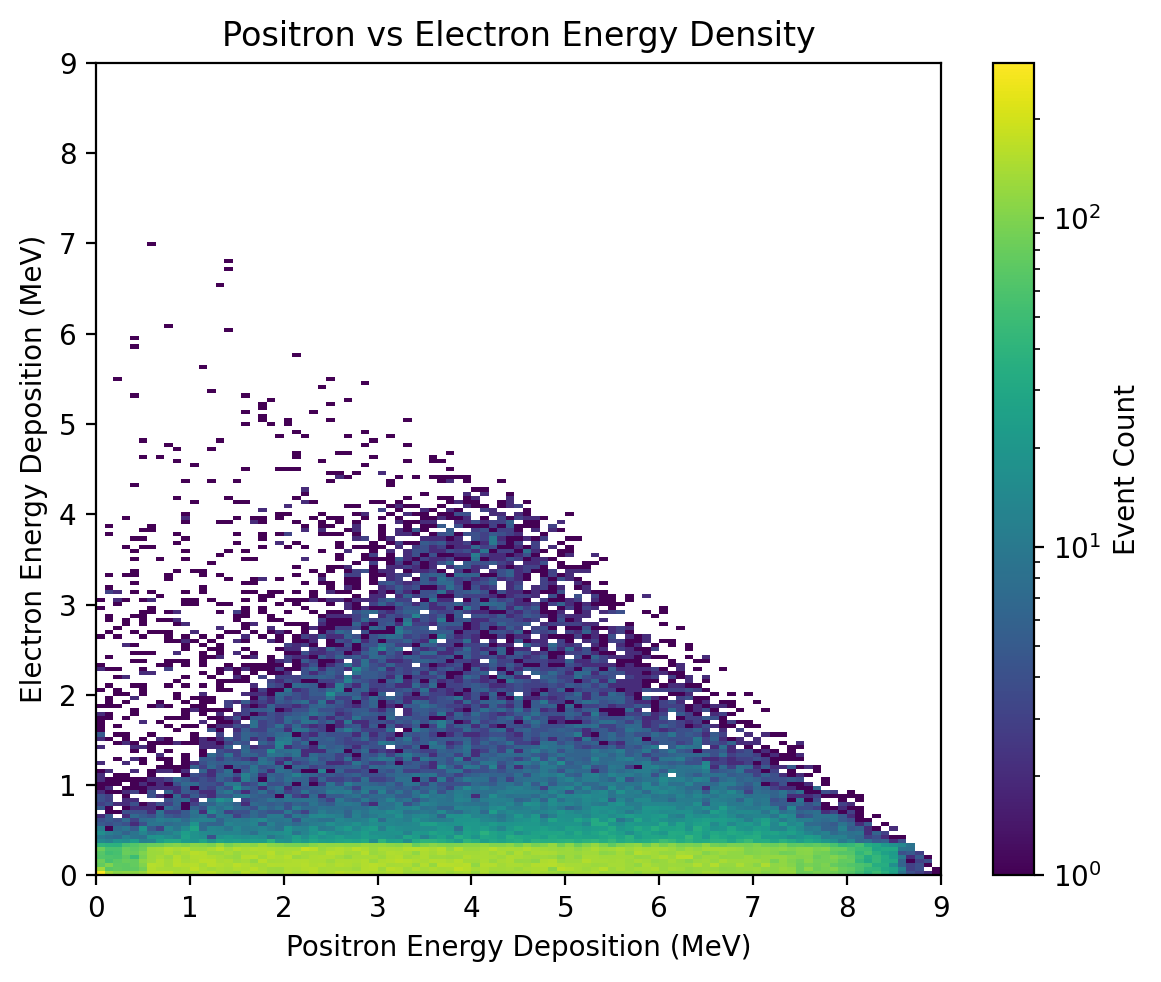

In [236]:
# 8. 粒子相关性分析：正电子和电子在同一事件中的能量关系
# 提取正电子和电子的事件级数据
positron_data = event_particle_stats[event_particle_stats["Particle"] == "Positron"][["EventID", "Total_Edep"]]
electron_data = event_particle_stats[event_particle_stats["Particle"] == "Electron"][["EventID", "Total_Edep"]]

positron_data = positron_data.rename(columns={"Total_Edep": "Positron_Edep"})
electron_data = electron_data.rename(columns={"Total_Edep": "Electron_Edep"})

# 合并数据
e_correlation = pd.merge(positron_data, electron_data, on="EventID", how="outer").fillna(0)

print("正电子-电子能量相关性分析:")
print(f"有正电子沉积的事件数: {(e_correlation['Positron_Edep'] > 0).sum()}")
print(f"有电子沉积的事件数: {(e_correlation['Electron_Edep'] > 0).sum()}")
print(f"同时有两者的事件数: {((e_correlation['Positron_Edep'] > 0) & (e_correlation['Electron_Edep'] > 0)).sum()}")

# 可视化
fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# 散点图：正电子 vs 电子能量


# 2D直方图
ax = axes
ax.hist2d(e_correlation[mask]["Positron_Edep"], e_correlation[mask]["Electron_Edep"], bins=(np.linspace(0, 9, 100), np.linspace(0, 9, 200)), cmap="viridis", norm=LogNorm())
ax.set_xlabel("Positron Energy Deposition (MeV)")
ax.set_ylabel("Electron Energy Deposition (MeV)")
ax.set_title("Positron vs Electron Energy Density")

plt.colorbar(ax.collections[0], ax=ax, label="Event Count")

plt.tight_layout()
plt.show()

## Cube 统计

分析每个事件中不同 Crystal 被击中的数量 (Crystal Multiplicity)

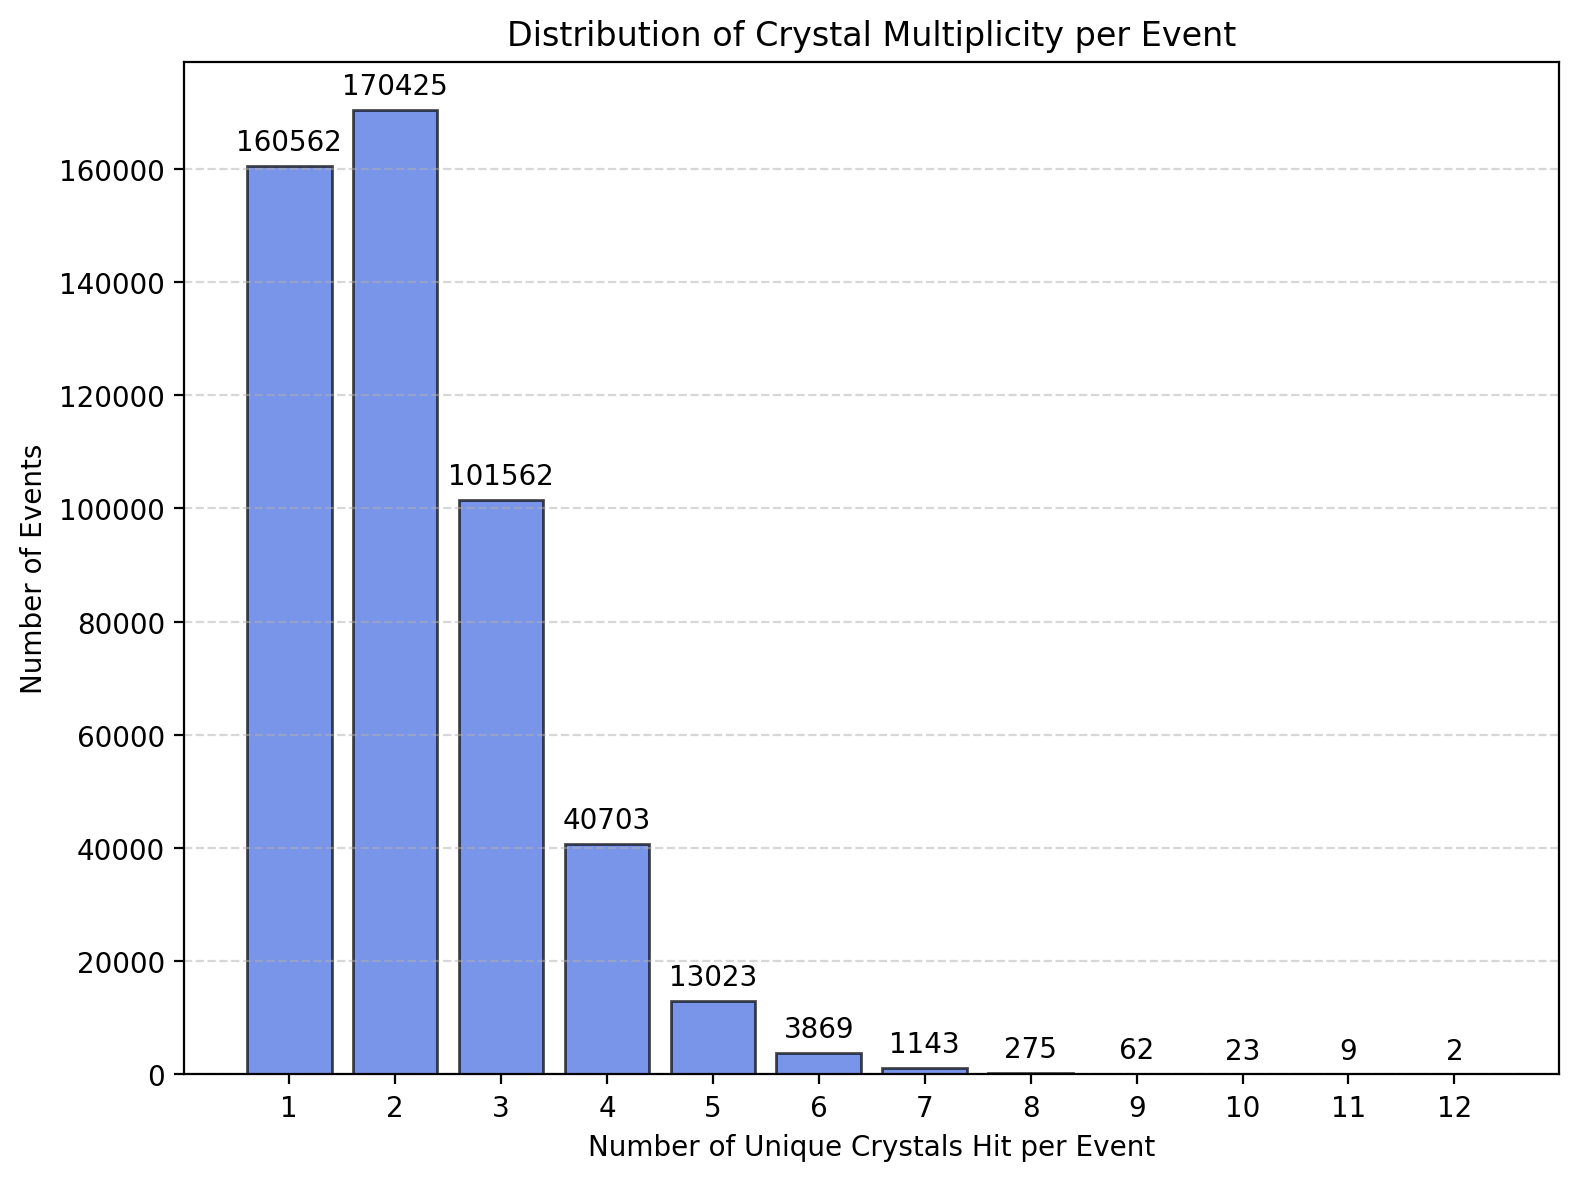

Crystal Multiplicity 统计:
  平均每个事件击中: 2.17 个 Crystal
  中位数: 2.0 个
  最大值: 12 个
  单晶体事件占比: 32.7%


In [ ]:
crystal_counts_per_event = df_hits.groupby("EventID")["crystalID"].nunique()

# 2. 绘图
plt.figure(figsize=(8, 6))

# 确定直方图的 bin 范围 (从 1 到 最大值)
max_crystals = int(crystal_counts_per_event.max())
bins = range(1, max_crystals + 2)  # +2 是为了包含最大值并在右侧留空

# 绘制直方图
n, bins, patches = plt.hist(crystal_counts_per_event, bins=bins, align="left", rwidth=0.8, color="royalblue", alpha=0.7, edgecolor="black")

plt.xlabel("Number of Unique Crystals Hit per Event")
plt.ylabel("Number of Events")
plt.title("Distribution of Crystal Multiplicity per Event")
plt.xticks(bins[:-1])  # 设置 x 轴刻度为整数
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 在柱状图上方添加具体数值标签
for i in range(len(n)):
    if n[i] > 0:
        plt.text(bins[i], n[i] + max(n) * 0.01, str(int(n[i])), ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"Crystal Multiplicity 统计:")
print(f"  平均每个事件击中: {crystal_counts_per_event.mean():.2f} 个 Crystal")
print(f"  中位数: {crystal_counts_per_event.median()} 个")
print(f"  最大值: {crystal_counts_per_event.max()} 个")
print(f"  单晶体事件占比: {(crystal_counts_per_event == 1).mean():.1%}")

### Cube 之间的弥散程度

坐标索引解码示例 (前5行):
   crystalID  ix  iy  iz
0      70001   7   0   1
1      20601   2   6   1
2      20602   2   6   2
3      20502   2   5   2
4      10601   1   6   1


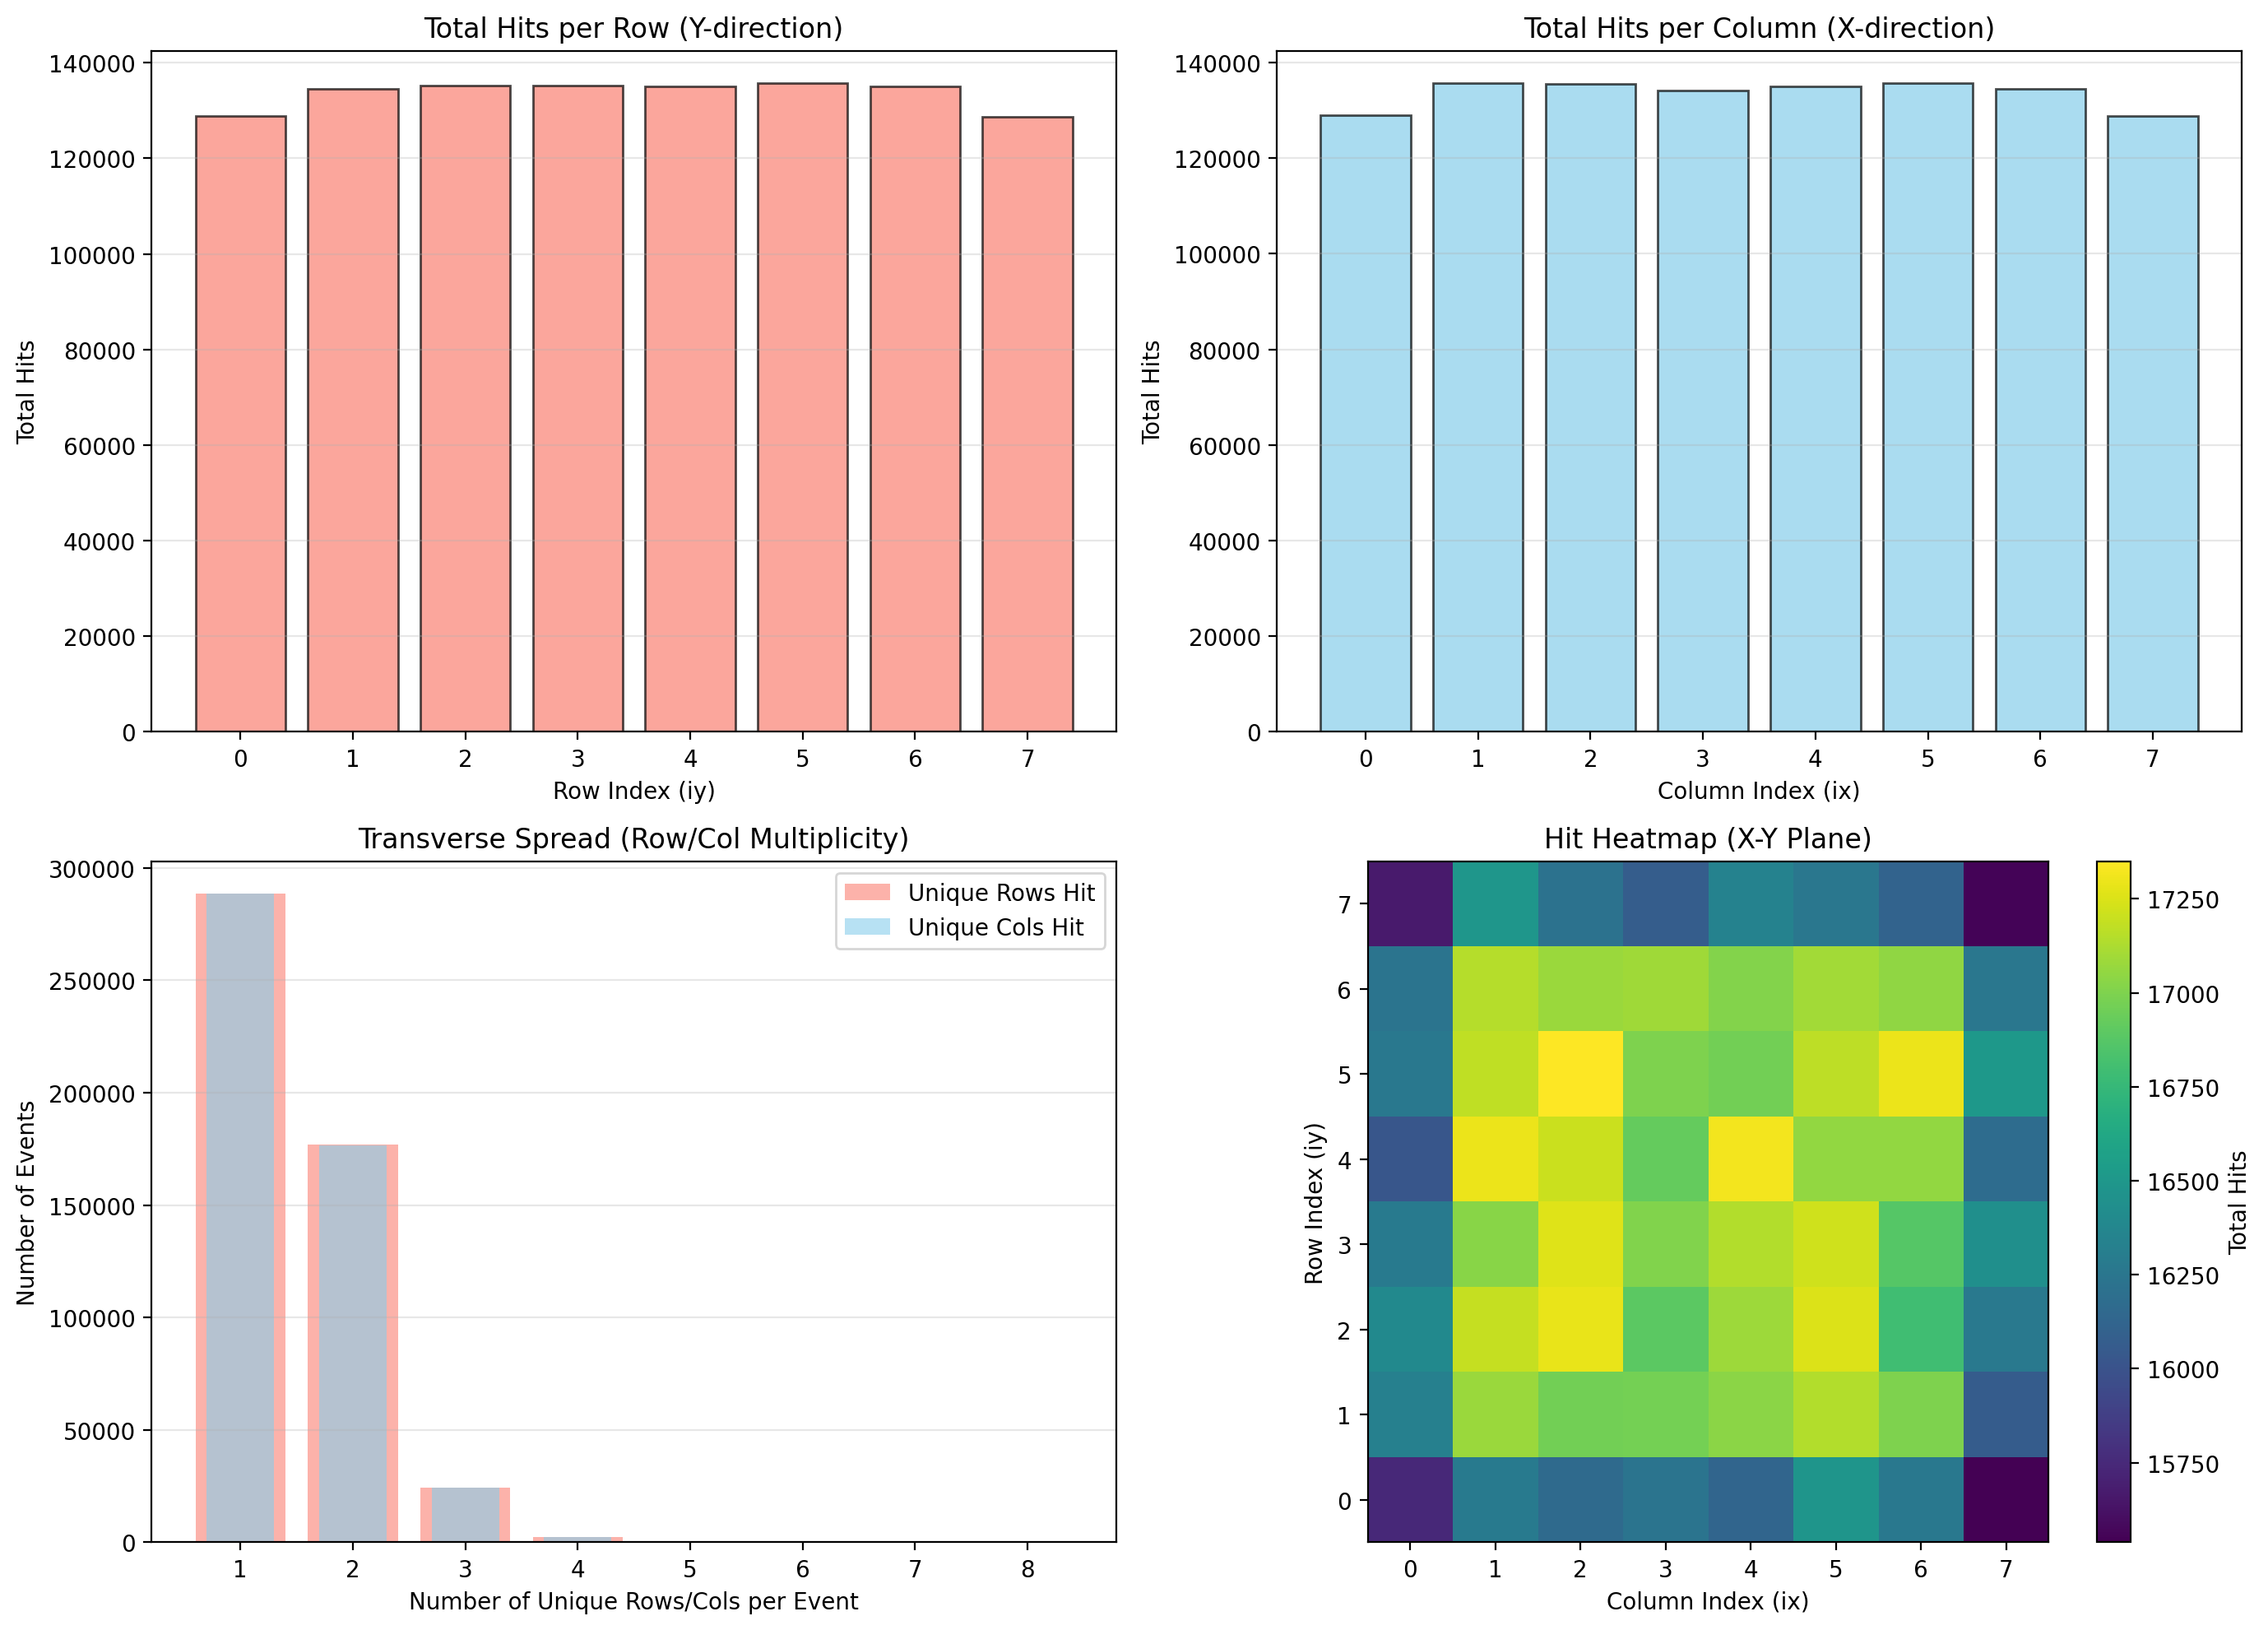

横向扩展统计:
  平均涉及行数: 1.47
  平均涉及列数: 1.47
  平均涉及层数: 1.43


In [269]:
# 1. 解码 CrystalID 获取空间坐标索引
# 根据 DetectorConstruction.cc: ID = ix * 10000 + iy * 100 + iz
# ix: 0-7 (Column), iy: 0-7 (Row), iz: 0-4 (Layer)
df_hits["ix"] = df_hits["crystalID"] // 10000
df_hits["iy"] = (df_hits["crystalID"] % 10000) // 100
df_hits["iz"] = df_hits["crystalID"] % 100

print("坐标索引解码示例 (前5行):")
print(df_hits[["crystalID", "ix", "iy", "iz"]].head())

# 2. 统计不同行(Row/iy) 和 不同列(Column/ix) 的击中总数 (Occupancy)
# 这反映了束流的轮廓或探测器的几何接受度
row_counts = df_hits["iy"].value_counts().sort_index()
col_counts = df_hits["ix"].value_counts().sort_index()

# 3. 统计每个事件涉及的 行数 和 列数 (Spread)
# 这反映了簇射的横向扩展范围
event_spread = df_hits.groupby("EventID").agg({"ix": "nunique", "iy": "nunique", "iz": "nunique"}).rename(columns={"ix": "N_Cols", "iy": "N_Rows", "iz": "N_Layers"})

# ==========================================
# 绘图
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 图 1: 行击中分布 (Row Occupancy)
axes[0, 0].bar(row_counts.index, row_counts.values, color="salmon", alpha=0.7, edgecolor="black")
axes[0, 0].set_xlabel("Row Index (iy)")
axes[0, 0].set_ylabel("Total Hits")
axes[0, 0].set_title("Total Hits per Row (Y-direction)")
axes[0, 0].set_xticks(range(8))
axes[0, 0].grid(axis="y", alpha=0.3)

# 图 2: 列击中分布 (Column Occupancy)
axes[0, 1].bar(col_counts.index, col_counts.values, color="skyblue", alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("Column Index (ix)")
axes[0, 1].set_ylabel("Total Hits")
axes[0, 1].set_title("Total Hits per Column (X-direction)")
axes[0, 1].set_xticks(range(8))
axes[0, 1].grid(axis="y", alpha=0.3)

# 图 3: 每个事件涉及的行数/列数分布 (Spread)
# 使用 offset 稍微错开显示
bins = np.arange(0.5, 9.5, 1)
axes[1, 0].hist(event_spread["N_Rows"], bins=bins, alpha=0.6, label="Unique Rows Hit", color="salmon", rwidth=0.8)
axes[1, 0].hist(event_spread["N_Cols"], bins=bins, alpha=0.6, label="Unique Cols Hit", color="skyblue", rwidth=0.6)
axes[1, 0].set_xlabel("Number of Unique Rows/Cols per Event")
axes[1, 0].set_ylabel("Number of Events")
axes[1, 0].set_title("Transverse Spread (Row/Col Multiplicity)")
axes[1, 0].legend()
axes[1, 0].set_xticks(range(1, 9))
axes[1, 0].grid(axis="y", alpha=0.3)

# 图 4: 2D 击中热图 (X-Y Occupancy)
# 聚合所有 Z 层的击中
xy_counts = df_hits.groupby(["ix", "iy"]).size().unstack(fill_value=0)
# 补全可能缺失的行列
for i in range(8):
    if i not in xy_counts.index:
        xy_counts.loc[i] = 0
    if i not in xy_counts.columns:
        xy_counts[i] = 0
xy_counts = xy_counts.sort_index().sort_index(axis=1)

im = axes[1, 1].imshow(xy_counts.values.T, origin="lower", cmap="viridis", interpolation="nearest")
axes[1, 1].set_xlabel("Column Index (ix)")
axes[1, 1].set_ylabel("Row Index (iy)")
axes[1, 1].set_title("Hit Heatmap (X-Y Plane)")
axes[1, 1].set_xticks(range(8))
axes[1, 1].set_yticks(range(8))
plt.colorbar(im, ax=axes[1, 1], label="Total Hits")

plt.tight_layout()
plt.show()

print("横向扩展统计:")
print(f"  平均涉及行数: {event_spread['N_Rows'].mean():.2f}")
print(f"  平均涉及列数: {event_spread['N_Cols'].mean():.2f}")
print(f"  平均涉及层数: {event_spread['N_Layers'].mean():.2f}")